# Strategic Bets Framework for Indonesia

**Implementation of the Strategic Bets Framework using Economic Complexity Theory**

This notebook implements a strategic diversification framework that identifies optimal export opportunities based on:
- **Efficiency Score** = PCI / Effort (complexity gain per unit of effort)
- **Effort** = Distance = 1 - Density (capability gap to overcome)
- **Strategic Value** = Balance between feasibility and complexity gain

## Data Source:
- **Harvard Atlas of Economic Complexity** (HS92 classification)
- Pre-calculated metrics: PCI, COG, Distance, RCA

## Framework Components:
1. ✅ Calculate Efficiency Scores (PCI/Effort) for all opportunities
2. ✅ Rank strategic bets by efficiency and strategic criteria
3. ✅ Visualize strategic bets on Product Space network
4. ✅ Generate actionable recommendations with product details

## 1. Setup & Configuration

In [12]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import os
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [13]:
# Configuration
DATA_DIR = 'D:/download/hs_data/'  # Path to Harvard Atlas data files
OUTPUT_DIR = './output/strategic_bets/'  # Where to save results
ANALYSIS_YEAR = 2023
INDONESIA_CODE = 'IDN'

# Strategic Bets Framework Parameters
MIN_PCI = 0.0           # Minimum complexity threshold
MIN_DENSITY = 0.05      # Minimum feasibility threshold (5% connection)
MAX_DISTANCE = 0.95     # Maximum effort threshold (95% distance)
TOP_N_BETS = 20         # Number of top strategic bets to identify

# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"✓ Output directory: {os.path.abspath(OUTPUT_DIR)}")
print(f"✓ Analysis year: {ANALYSIS_YEAR}")
print(f"✓ Country: {INDONESIA_CODE}")

✓ Output directory: c:\tortoise\cottonborry\output\strategic_bets
✓ Analysis year: 2023
✓ Country: IDN


## 2. Load Data

In [14]:
print("Loading datasets...\n")

# Main country-product trade data with pre-calculated metrics
df_trade = pd.read_csv(f'{DATA_DIR}hs92_country_product_year_4.csv')
print(f"✓ Country-Product Trade data: {df_trade.shape}")
print(f"  Columns: {list(df_trade.columns)}")

# Product metadata
df_products = pd.read_csv(f'{DATA_DIR}product_hs92.csv')
print(f"✓ Product Metadata: {df_products.shape}")

# UMAP layout for visualization
df_umap = pd.read_csv(f'{DATA_DIR}umap_layout_hs92.csv')
print(f"✓ UMAP Layout data: {df_umap.shape}")

# Product Space edges
df_edges = pd.read_csv(f'{DATA_DIR}top_edges_hs92.csv')
print(f"✓ Product Edges data: {df_edges.shape}")

print(f"\n📊 Data Overview:")
print(f"  • Years available: {df_trade['year'].min()} - {df_trade['year'].max()}")
print(f"  • Number of countries: {df_trade['country_iso3_code'].nunique()}")
print(f"  • Number of products: {df_trade['product_hs92_code'].nunique()}")
print("\n✅ All datasets loaded successfully!")

Loading datasets...

✓ Country-Product Trade data: (6497429, 12)
  Columns: ['country_id', 'country_iso3_code', 'product_id', 'product_hs92_code', 'year', 'export_value', 'import_value', 'global_market_share', 'export_rca', 'distance', 'cog', 'pci']
✓ Product Metadata: (6390, 10)
✓ UMAP Layout data: (865, 4)
✓ Product Edges data: (4316, 2)

📊 Data Overview:
  • Years available: 1995 - 2023
  • Number of countries: 242
  • Number of products: 2485

✅ All datasets loaded successfully!


## 3. Prepare Indonesia Data

In [15]:
print(f"Filtering data for {INDONESIA_CODE} in year {ANALYSIS_YEAR}...\n")

# Filter for analysis year
df_year = df_trade[df_trade['year'] == ANALYSIS_YEAR].copy()

# Get Indonesia specific data
df_indonesia = df_year[df_year['country_iso3_code'] == INDONESIA_CODE].copy()

# Merge product names
df_indonesia = df_indonesia.merge(
    df_products[['product_hs92_code', 'product_name_short', 'product_name']], 
    on='product_hs92_code', 
    how='left'
)

# Calculate density from distance
df_indonesia['density'] = 1 - df_indonesia['distance']

# Identify current exports (RCA >= 1)
df_indonesia['has_rca'] = (df_indonesia['export_rca'] >= 1).astype(int)

print(f"📊 Indonesia Trade Summary ({ANALYSIS_YEAR}):")
print(f"  • Total products traded: {len(df_indonesia)}")
print(f"  • Products with RCA >= 1: {df_indonesia['has_rca'].sum()}")
print(f"  • Export opportunities (RCA < 1): {(df_indonesia['has_rca'] == 0).sum()}")
print(f"  • Total exports: ${df_indonesia['export_value'].sum():,.0f}")
print(f"  • Average PCI (current exports): {df_indonesia[df_indonesia['has_rca']==1]['pci'].mean():.3f}")

Filtering data for IDN in year 2023...

📊 Indonesia Trade Summary (2023):
  • Total products traded: 1212
  • Products with RCA >= 1: 225
  • Export opportunities (RCA < 1): 987
  • Total exports: $253,349,308,484
  • Average PCI (current exports): -0.540


## 4. Calculate Strategic Bets Framework Metrics

### Key Metrics:
- **Effort** = Distance = 1 - Density (how hard to acquire capabilities)
- **Efficiency** = PCI / Effort (complexity gain per unit of effort)
- **Strategic Score** = Weighted combination considering feasibility, complexity, and future value

In [16]:
print("Calculating Strategic Bets Framework Metrics...\n")

# Focus on export opportunities (products not currently exported with RCA >= 1)
opportunities = df_indonesia[df_indonesia['has_rca'] == 0].copy()

print(f"📊 Total export opportunities: {len(opportunities)}")

# Calculate Effort (distance/cost to acquire capabilities)
opportunities['effort'] = opportunities['distance']

# Calculate Efficiency Score (PCI / Effort)
# Higher efficiency = more complexity gain per unit of effort
# Add small constant to avoid division by zero
opportunities['efficiency'] = opportunities['pci'] / (opportunities['effort'] + 0.001)

# Calculate Strategic Score (multi-factor)
# Combines: efficiency, absolute complexity, feasibility, and future value (COG)
# Normalize components to 0-1 scale for fair weighting

def normalize(series):
    """Normalize to 0-1 scale"""
    min_val = series.min()
    max_val = series.max()
    if max_val == min_val:
        return pd.Series(0, index=series.index)
    return (series - min_val) / (max_val - min_val)

# Filter for viable opportunities
viable_opps = opportunities[
    (opportunities['pci'] >= MIN_PCI) & 
    (opportunities['density'] >= MIN_DENSITY) &
    (opportunities['distance'] <= MAX_DISTANCE)
].copy()

print(f"📊 Viable opportunities (after filters): {len(viable_opps)}")
print(f"   • Min PCI: {MIN_PCI}")
print(f"   • Min Density: {MIN_DENSITY}")
print(f"   • Max Distance: {MAX_DISTANCE}")

if len(viable_opps) > 0:
    # Normalize metrics
    viable_opps['norm_efficiency'] = normalize(viable_opps['efficiency'])
    viable_opps['norm_pci'] = normalize(viable_opps['pci'])
    viable_opps['norm_density'] = normalize(viable_opps['density'])
    viable_opps['norm_cog'] = normalize(viable_opps['cog'])
    
    # Strategic Score = weighted combination
    # Weights: efficiency (40%), PCI (30%), density (20%), COG (10%)
    viable_opps['strategic_score'] = (
        0.40 * viable_opps['norm_efficiency'] +
        0.30 * viable_opps['norm_pci'] +
        0.20 * viable_opps['norm_density'] +
        0.10 * viable_opps['norm_cog']
    )
    
    print(f"\n✅ Strategic metrics calculated!")
    print(f"\n📈 Metric Ranges:")
    print(f"   • Efficiency: {viable_opps['efficiency'].min():.3f} to {viable_opps['efficiency'].max():.3f}")
    print(f"   • PCI: {viable_opps['pci'].min():.3f} to {viable_opps['pci'].max():.3f}")
    print(f"   • Density: {viable_opps['density'].min():.3f} to {viable_opps['density'].max():.3f}")
    print(f"   • Distance/Effort: {viable_opps['effort'].min():.3f} to {viable_opps['effort'].max():.3f}")
    print(f"   • COG: {viable_opps['cog'].min():.3f} to {viable_opps['cog'].max():.3f}")
else:
    print("\n⚠️ No viable opportunities found with current filters!")

Calculating Strategic Bets Framework Metrics...

📊 Total export opportunities: 987
📊 Viable opportunities (after filters): 568
   • Min PCI: 0.0
   • Min Density: 0.05
   • Max Distance: 0.95

✅ Strategic metrics calculated!

📈 Metric Ranges:
   • Efficiency: 0.001 to 4.014
   • PCI: 0.001 to 3.472
   • Density: 0.110 to 0.225
   • Distance/Effort: 0.775 to 0.890
   • COG: 0.001 to 1.594


## 5. Identify Top Strategic Bets

In [17]:
print(f"Identifying Top {TOP_N_BETS} Strategic Bets...\n")

# Rank by strategic score
strategic_bets = viable_opps.nlargest(TOP_N_BETS, 'strategic_score').copy()

# Also get top bets by pure efficiency
top_efficiency = viable_opps.nlargest(TOP_N_BETS, 'efficiency').copy()

print(f"✅ Identified {len(strategic_bets)} strategic bets\n")

# Display strategic bets
print("="*100)
print(f"TOP {len(strategic_bets)} STRATEGIC BETS FOR INDONESIA ({ANALYSIS_YEAR})")
print("="*100)

display_cols = [
    'product_hs92_code', 'product_name_short', 
    'pci', 'density', 'effort', 'efficiency', 'cog', 'strategic_score'
]

strategic_bets_display = strategic_bets[display_cols].copy()
strategic_bets_display.columns = [
    'HS Code', 'Product Name', 'PCI', 'Density', 'Effort', 
    'Efficiency', 'COG', 'Score'
]
strategic_bets_display = strategic_bets_display.reset_index(drop=True)
strategic_bets_display.index = strategic_bets_display.index + 1

# Format for display
pd.options.display.float_format = '{:.3f}'.format
display(strategic_bets_display)

print(f"\n💡 Interpretation:")
print(f"   • PCI: Product complexity (higher = more complex/valuable)")
print(f"   • Density: Relatedness to current capabilities (higher = easier to develop)")
print(f"   • Effort: Distance/cost to acquire (lower = easier)")
print(f"   • Efficiency: PCI/Effort ratio (higher = better ROI on effort)")
print(f"   • COG: Complexity Outlook Gain (future strategic value)")
print(f"   • Score: Weighted strategic score (0-1, higher = better overall bet)")

Identifying Top 20 Strategic Bets...

✅ Identified 20 strategic bets

TOP 20 STRATEGIC BETS FOR INDONESIA (2023)


,HS Code,Product Name,PCI,Density,Effort,Efficiency,COG,Score
1,2841,Salts of oxometallic acids,3.472,0.136,0.864,4.014,0.002,0.745
2,7006,Worked glass,2.398,0.177,0.823,2.910,0.979,0.675
3,3705,"Photographic film, developed",2.826,0.111,0.889,3.175,0.956,0.622
4,8479,Machines n.e.c.,2.244,0.140,0.860,2.606,1.429,0.595
5,8444,"Machines to extrude, cut manmade textile fibres",2.473,0.126,0.874,2.826,1.111,0.593
6,3707,Chemical preparations for photographic uses,2.441,0.136,0.864,2.822,0.804,0.588
7,7506,Nickel plates,2.565,0.110,0.890,2.879,1.183,0.583
8,9110,"Clock movements, complete, unassembled",1.926,0.179,0.821,2.343,0.740,0.566
9,7221,"Bars of stainless steel, hot-rolled",2.130,0.136,0.864,2.462,1.225,0.551
10,3818,Chemical elements for electronics,1.865,0.164,0.836,2.228,1.155,0.549



💡 Interpretation:
   • PCI: Product complexity (higher = more complex/valuable)
   • Density: Relatedness to current capabilities (higher = easier to develop)
   • Effort: Distance/cost to acquire (lower = easier)
   • Efficiency: PCI/Effort ratio (higher = better ROI on effort)
   • COG: Complexity Outlook Gain (future strategic value)
   • Score: Weighted strategic score (0-1, higher = better overall bet)


## 6. Comparative Analysis: Different Ranking Approaches

In [18]:
print("Comparing different ranking approaches...\n")

# Top 10 by each metric
top_by_efficiency = viable_opps.nlargest(10, 'efficiency')[['product_hs92_code', 'product_name_short', 'efficiency', 'pci', 'density']]
top_by_pci = viable_opps.nlargest(10, 'pci')[['product_hs92_code', 'product_name_short', 'pci', 'efficiency', 'density']]
top_by_density = viable_opps.nlargest(10, 'density')[['product_hs92_code', 'product_name_short', 'density', 'efficiency', 'pci']]
top_by_cog = viable_opps.nlargest(10, 'cog')[['product_hs92_code', 'product_name_short', 'cog', 'efficiency', 'pci']]

print("🏆 Top 10 by EFFICIENCY (PCI/Effort):")
print("   (Best complexity gain per unit of effort)\n")
for i, row in top_by_efficiency.iterrows():
    print(f"   {row['product_hs92_code']}: {row['product_name_short'][:50]}")
    print(f"      Efficiency={row['efficiency']:.3f}, PCI={row['pci']:.3f}, Density={row['density']:.3f}")

print("\n🧠 Top 10 by COMPLEXITY (PCI):")
print("   (Highest complexity products)\n")
for i, row in top_by_pci.iterrows():
    print(f"   {row['product_hs92_code']}: {row['product_name_short'][:50]}")
    print(f"      PCI={row['pci']:.3f}, Efficiency={row['efficiency']:.3f}, Density={row['density']:.3f}")

print("\n🎯 Top 10 by FEASIBILITY (Density):")
print("   (Easiest to develop given current capabilities)\n")
for i, row in top_by_density.iterrows():
    print(f"   {row['product_hs92_code']}: {row['product_name_short'][:50]}")
    print(f"      Density={row['density']:.3f}, Efficiency={row['efficiency']:.3f}, PCI={row['pci']:.3f}")

print("\n🔮 Top 10 by FUTURE VALUE (COG):")
print("   (Highest future diversification potential)\n")
for i, row in top_by_cog.iterrows():
    print(f"   {row['product_hs92_code']}: {row['product_name_short'][:50]}")
    print(f"      COG={row['cog']:.3f}, Efficiency={row['efficiency']:.3f}, PCI={row['pci']:.3f}")

Comparing different ranking approaches...

🏆 Top 10 by EFFICIENCY (PCI/Effort):
   (Best complexity gain per unit of effort)

   2841: Salts of oxometallic acids
      Efficiency=4.014, PCI=3.472, Density=0.136
   3705: Photographic film, developed
      Efficiency=3.175, PCI=2.826, Density=0.111
   7006: Worked glass
      Efficiency=2.910, PCI=2.398, Density=0.177
   7506: Nickel plates
      Efficiency=2.879, PCI=2.565, Density=0.110
   8444: Machines to extrude, cut manmade textile fibres
      Efficiency=2.826, PCI=2.473, Density=0.126
   3707: Chemical preparations for photographic uses
      Efficiency=2.822, PCI=2.441, Density=0.136
   8479: Machines n.e.c.
      Efficiency=2.606, PCI=2.244, Density=0.140
   8113: Cermets
      Efficiency=2.563, PCI=2.271, Density=0.115
   7221: Bars of stainless steel, hot-rolled
      Efficiency=2.462, PCI=2.130, Density=0.136
   8456: Machines for working materials by laser and simila
      Efficiency=2.388, PCI=2.073, Density=0.133

🧠 Top 1

## 7. Visualize Strategic Bets: Efficiency-Complexity Diagram

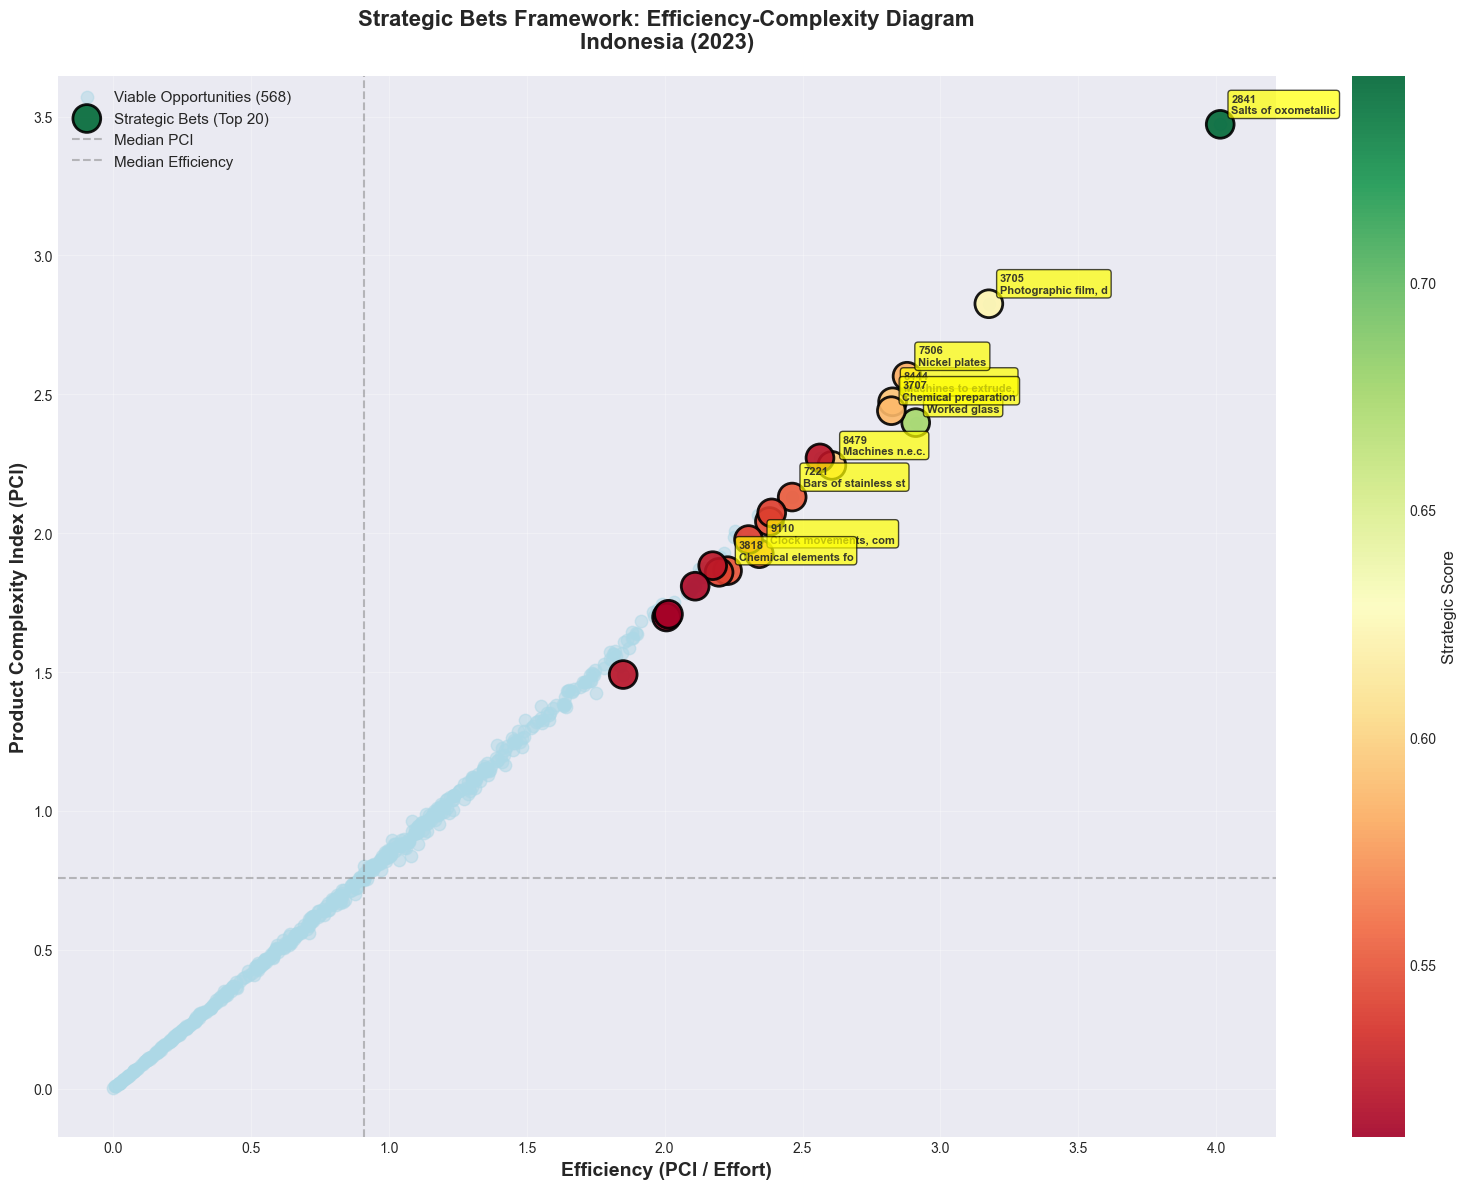

✅ Visualization saved: ./output/strategic_bets/strategic_bets_efficiency_complexity.png


In [19]:
# Create Efficiency-Complexity visualization
fig, ax = plt.subplots(figsize=(16, 12))

# Plot all viable opportunities
ax.scatter(viable_opps['efficiency'], viable_opps['pci'], 
           c='lightblue', s=80, alpha=0.5, label=f'Viable Opportunities ({len(viable_opps)})')

# Highlight strategic bets
ax.scatter(strategic_bets['efficiency'], strategic_bets['pci'],
           c=strategic_bets['strategic_score'], cmap='RdYlGn', 
           s=400, alpha=0.9, edgecolors='black', linewidths=2,
           label=f'Strategic Bets (Top {len(strategic_bets)})')

# Add colorbar for strategic score
cbar = plt.colorbar(ax.collections[1], ax=ax)
cbar.set_label('Strategic Score', fontsize=12)

# Label top strategic bets
for _, row in strategic_bets.head(10).iterrows():
    label = f"{row['product_hs92_code']}\n{str(row['product_name_short'])[:20]}"
    ax.annotate(label, 
                (row['efficiency'], row['pci']),
                xytext=(8, 8), textcoords='offset points',
                fontsize=8, fontweight='bold', alpha=0.9,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))

# Add reference lines
ax.axhline(y=viable_opps['pci'].median(), color='gray', linestyle='--', alpha=0.5, label='Median PCI')
ax.axvline(x=viable_opps['efficiency'].median(), color='gray', linestyle='--', alpha=0.5, label='Median Efficiency')

ax.set_xlabel('Efficiency (PCI / Effort)', fontsize=14, fontweight='bold')
ax.set_ylabel('Product Complexity Index (PCI)', fontsize=14, fontweight='bold')
ax.set_title(f'Strategic Bets Framework: Efficiency-Complexity Diagram\nIndonesia ({ANALYSIS_YEAR})', 
             fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
output_file = os.path.join(OUTPUT_DIR, 'strategic_bets_efficiency_complexity.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Visualization saved: {output_file}")

## 8. Visualize Strategic Bets on Product Space Network

Building Product Space Network with Strategic Bets...

✓ Network: 865 nodes, 2158 edges
✓ Layout: 865 product positions

📊 Products in network:
   • Current exports: 160
   • Strategic bets: 15
   • Other products: 690


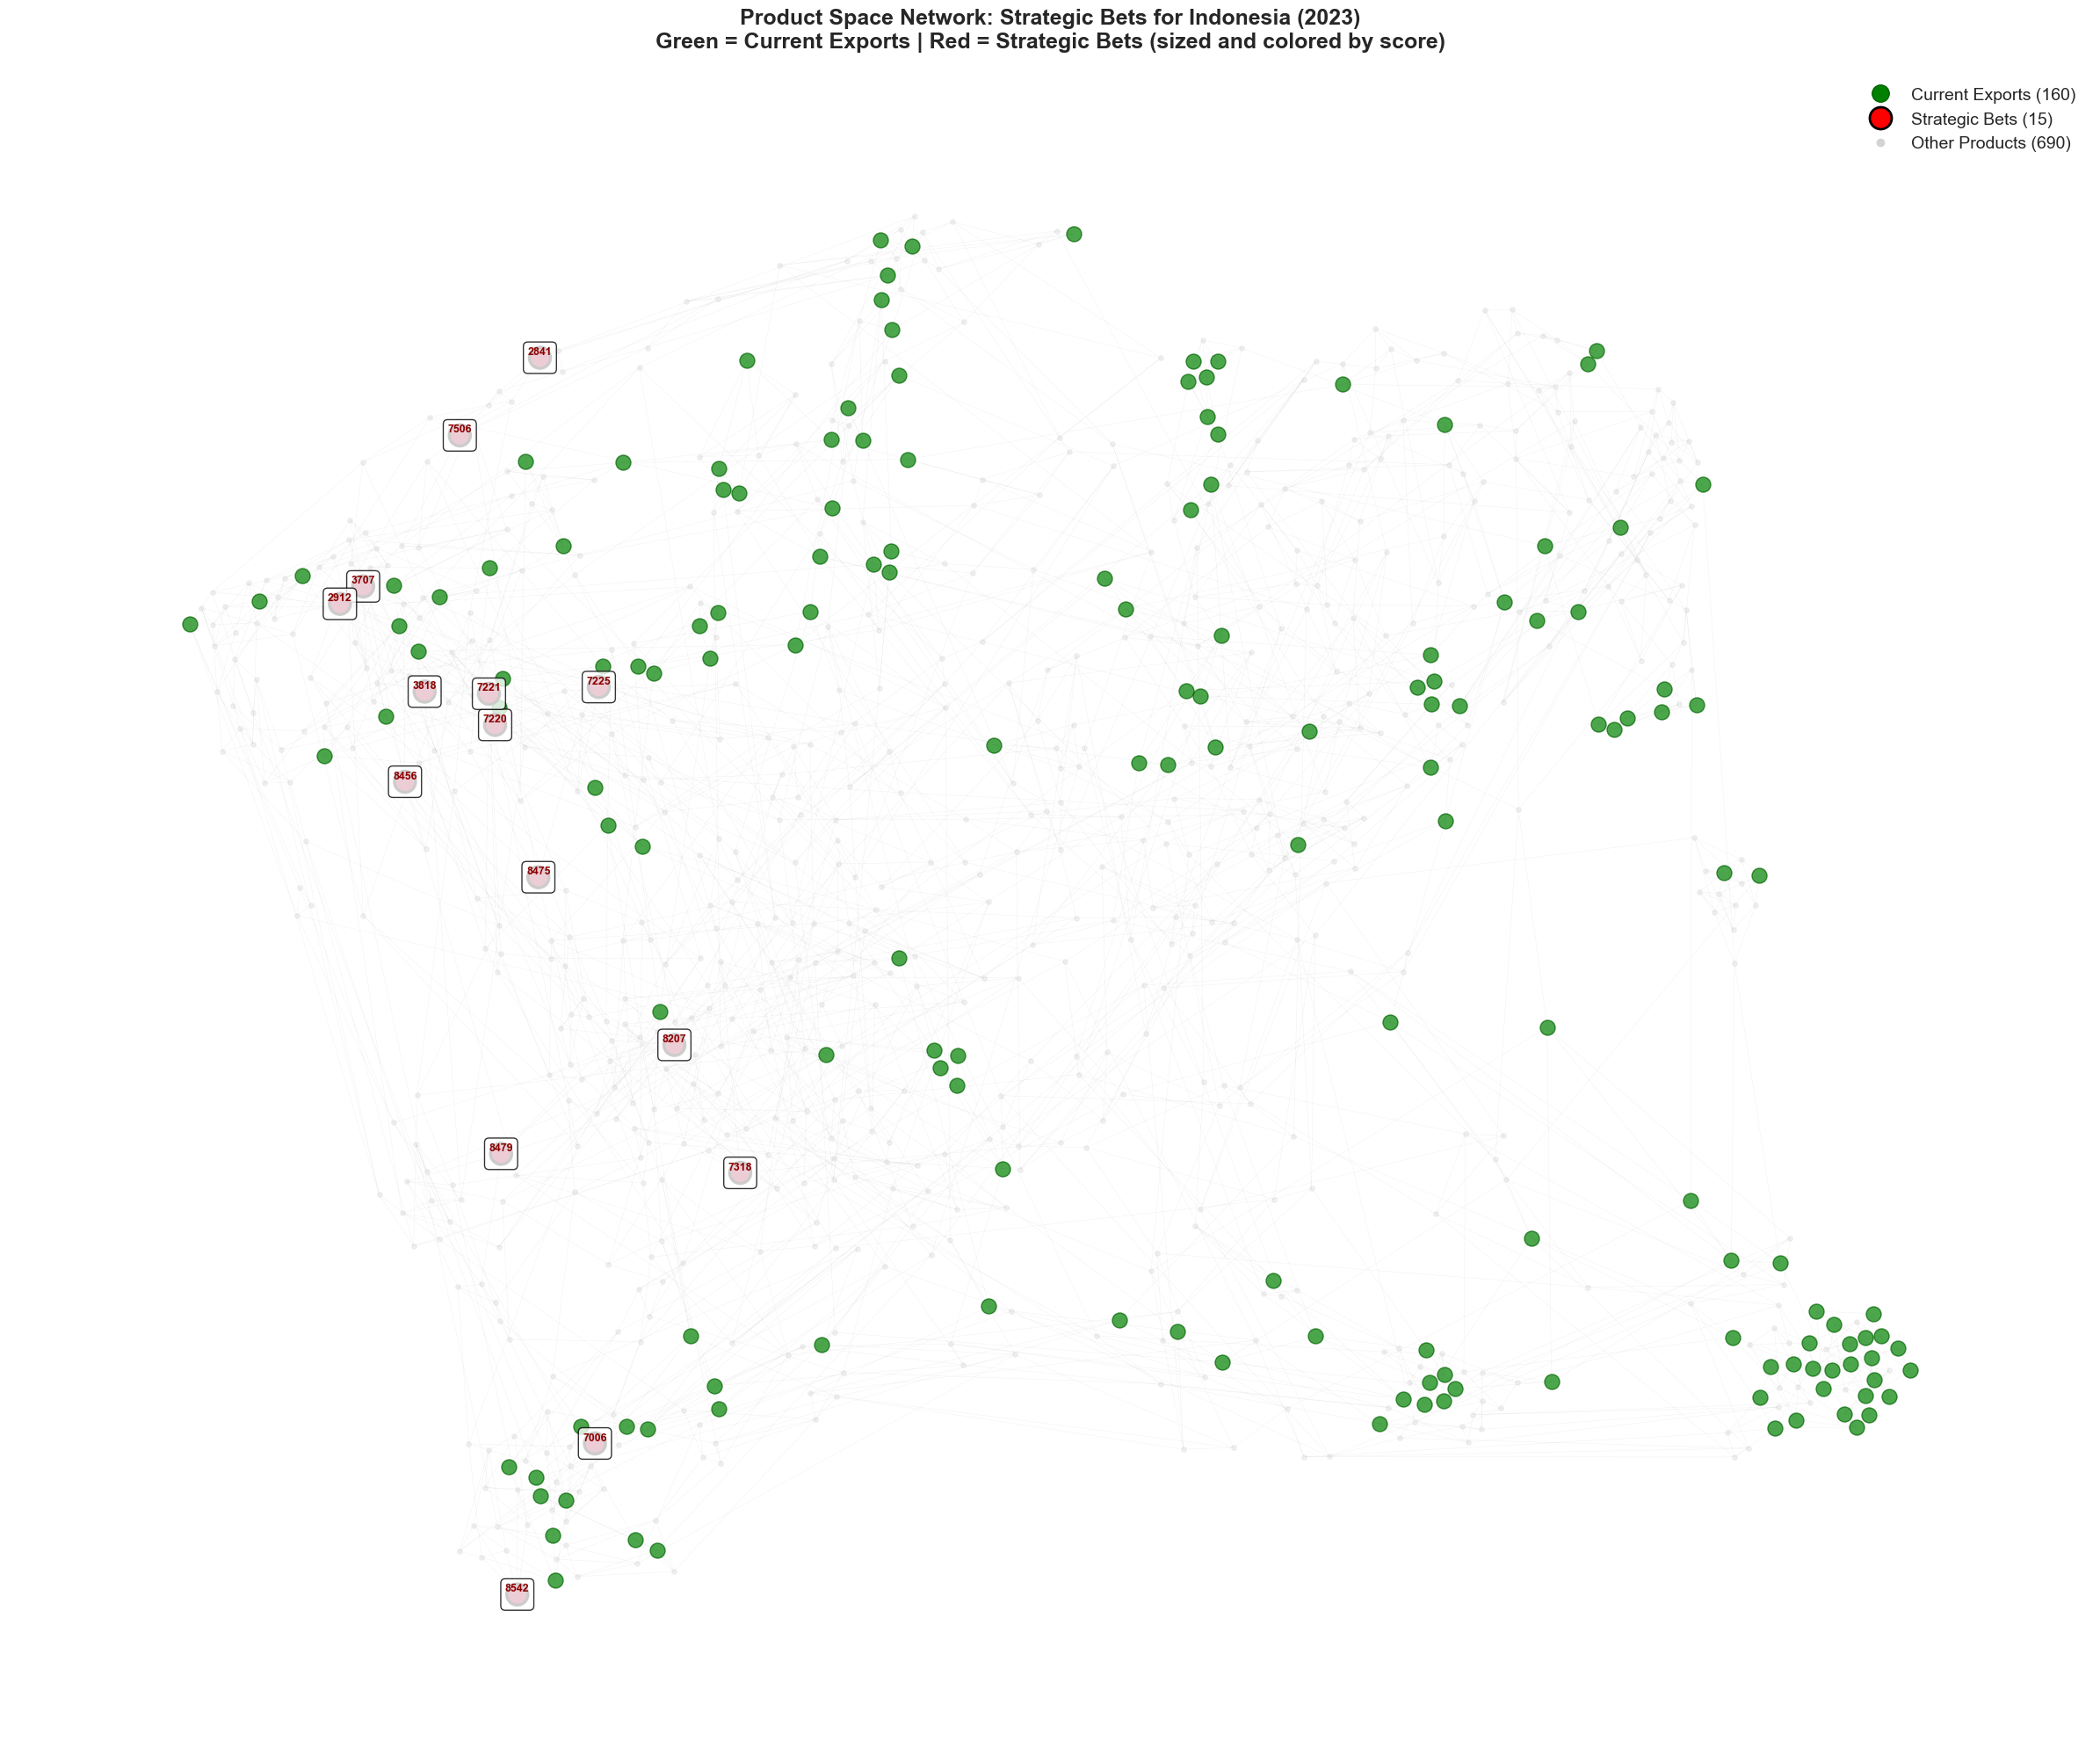


✅ Product Space visualization saved: ./output/strategic_bets/strategic_bets_product_space.png


In [20]:
print("Building Product Space Network with Strategic Bets...\n")

# Create network from Harvard Atlas edges
G = nx.Graph()
for _, row in df_edges.iterrows():
    source = str(row['product_hs92_code_source'])
    target = str(row['product_hs92_code_target'])
    G.add_edge(source, target)

print(f"✓ Network: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# Use UMAP layout
pos = {}
for _, row in df_umap.iterrows():
    pos[str(row['product_hs92_code'])] = (row['product_space_x'], row['product_space_y'])

print(f"✓ Layout: {len(pos)} product positions")

# Categorize products
current_exports = df_indonesia[df_indonesia['has_rca'] == 1]
current_set = set(str(x) for x in current_exports['product_hs92_code'].tolist())
strategic_set = set(str(x) for x in strategic_bets['product_hs92_code'].tolist())
nodes_in_graph = set(G.nodes())

nodes_current = [n for n in G.nodes() if n in current_set]
nodes_strategic = [n for n in G.nodes() if n in strategic_set and n not in current_set]
nodes_other = [n for n in G.nodes() if n not in current_set and n not in strategic_set]

print(f"\n📊 Products in network:")
print(f"   • Current exports: {len(nodes_current)}")
print(f"   • Strategic bets: {len(nodes_strategic)}")
print(f"   • Other products: {len(nodes_other)}")

# Create visualization
fig, ax = plt.subplots(figsize=(24, 20))

# Draw edges (light background)
nx.draw_networkx_edges(G, pos, alpha=0.12, width=0.3, edge_color='gray', ax=ax)

# Draw nodes by category
if nodes_other:
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_other, 
                          node_color='lightgray', node_size=15, alpha=0.3, ax=ax)

if nodes_current:
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_current,
                          node_color='green', node_size=150, alpha=0.7, ax=ax,
                          edgecolors='darkgreen', linewidths=1)

if nodes_strategic:
    # Color strategic bets by their strategic score
    strategic_colors = []
    strategic_sizes = []
    for n in nodes_strategic:
        score = strategic_bets[strategic_bets['product_hs92_code'] == int(n)]['strategic_score'].values
        if len(score) > 0:
            strategic_colors.append(score[0])
            strategic_sizes.append(300 + score[0] * 500)  # Size by score
        else:
            strategic_colors.append(0.5)
            strategic_sizes.append(300)
    
    nx.draw_networkx_nodes(G, pos, nodelist=nodes_strategic,
                          node_color=strategic_colors, cmap='RdYlGn',
                          node_size=strategic_sizes, alpha=0.95, ax=ax,
                          edgecolors='black', linewidths=2.5)

# Label top strategic bets
product_name_lookup = df_products.set_index('product_hs92_code')['product_name_short'].to_dict()
labels = {}
for p in strategic_set:
    if p in G.nodes() and p in pos:
        try:
            p_int = int(p)
            name = product_name_lookup.get(p_int, '')
            short_name = str(name)[:20] if name else ''
            labels[p] = f"{p}\n{short_name}"
        except:
            labels[p] = p

if labels:
    nx.draw_networkx_labels(G, pos, labels, font_size=9, font_weight='bold', 
                           font_color='darkred', ax=ax,
                           bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8))

# Title and legend
ax.set_title(f'Product Space Network: Strategic Bets for Indonesia ({ANALYSIS_YEAR})\n' +
            f'Green = Current Exports | Red = Strategic Bets (sized and colored by score)',
            fontsize=18, fontweight='bold', pad=20)
ax.axis('off')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=14, 
           markeredgecolor='darkgreen', markeredgewidth=1,
           label=f'Current Exports ({len(nodes_current)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=18,
           markeredgecolor='black', markeredgewidth=2,
           label=f'Strategic Bets ({len(nodes_strategic)})'),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='lightgray', markersize=8,
           label=f'Other Products ({len(nodes_other)})')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=14, framealpha=0.95)

plt.tight_layout()
output_file = os.path.join(OUTPUT_DIR, 'strategic_bets_product_space.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n✅ Product Space visualization saved: {output_file}")

## 9. Strategic Recommendations & Analysis

In [21]:
print("="*100)
print("STRATEGIC BETS FRAMEWORK: EXECUTIVE SUMMARY")
print(f"Indonesia ({ANALYSIS_YEAR})")
print("="*100)

# Current state
current_exports = df_indonesia[df_indonesia['has_rca'] == 1]
print(f"\n📊 CURRENT STATE:")
print(f"   • Products with RCA >= 1: {len(current_exports)}")
print(f"   • Average PCI (current): {current_exports['pci'].mean():.3f}")
print(f"   • Export value: ${current_exports['export_value'].sum():,.0f}")

# Strategic bets summary
print(f"\n🎯 STRATEGIC BETS IDENTIFIED: {len(strategic_bets)}")
print(f"   • Average PCI: {strategic_bets['pci'].mean():.3f}")
print(f"   • Average Density: {strategic_bets['density'].mean():.3f}")
print(f"   • Average Effort: {strategic_bets['effort'].mean():.3f}")
print(f"   • Average Efficiency: {strategic_bets['efficiency'].mean():.3f}")
print(f"   • Average COG: {strategic_bets['cog'].mean():.3f}")

# Impact analysis
pci_uplift = strategic_bets['pci'].mean() - current_exports['pci'].mean()
print(f"\n📈 POTENTIAL IMPACT:")
print(f"   • Complexity uplift: {pci_uplift:+.3f} PCI points")
print(f"   • Percentage increase: {(pci_uplift / abs(current_exports['pci'].mean())) * 100:.1f}%")
print(f"   • New products to develop: {len(strategic_bets)}")

# Top 5 detailed recommendations
print(f"\n🏆 TOP 5 STRATEGIC BETS (Detailed):")
print("="*100)
for rank, (_, bet) in enumerate(strategic_bets.head(5).iterrows(), 1):
    print(f"\n#{rank}: {bet['product_hs92_code']} - {bet['product_name_short']}")
    print(f"   Product: {bet['product_name'][:100] if pd.notna(bet.get('product_name')) else 'N/A'}")
    print(f"   Metrics:")
    print(f"      • Strategic Score: {bet['strategic_score']:.3f} (weighted composite)")
    print(f"      • Efficiency: {bet['efficiency']:.3f} (complexity gain per effort)")
    print(f"      • PCI: {bet['pci']:.3f} (product complexity)")
    print(f"      • Density: {bet['density']:.3f} (feasibility - {bet['density']*100:.1f}% related)")
    print(f"      • Effort: {bet['effort']:.3f} (distance to acquire)")
    print(f"      • COG: {bet['cog']:.3f} (future strategic value)")
    print(f"   Interpretation:")
    if bet['efficiency'] > viable_opps['efficiency'].quantile(0.75):
        print(f"      ✓ High efficiency - excellent return on effort")
    if bet['density'] > 0.15:
        print(f"      ✓ Good feasibility - {bet['density']*100:.0f}% connected to current capabilities")
    if bet['pci'] > 1.0:
        print(f"      ✓ High complexity - significant economic sophistication")
    if bet['cog'] > viable_opps['cog'].median():
        print(f"      ✓ High future value - gateway to other complex products")

# Policy recommendations
print(f"\n\n💡 POLICY RECOMMENDATIONS:")
print(f"\n1. SHORT-TERM (1-3 years):")
high_density_bets = strategic_bets[strategic_bets['density'] > strategic_bets['density'].median()].head(3)
for _, bet in high_density_bets.iterrows():
    print(f"   • {bet['product_hs92_code']}: {bet['product_name_short']} (Density: {bet['density']:.3f})")
print(f"   Rationale: High feasibility, leverages existing capabilities")

print(f"\n2. MEDIUM-TERM (3-5 years):")
balanced_bets = strategic_bets[
    (strategic_bets['density'] >= strategic_bets['density'].quantile(0.25)) &
    (strategic_bets['pci'] >= strategic_bets['pci'].median())
].head(3)
for _, bet in balanced_bets.iterrows():
    print(f"   • {bet['product_hs92_code']}: {bet['product_name_short']} (PCI: {bet['pci']:.3f}, Density: {bet['density']:.3f})")
print(f"   Rationale: Balance of complexity and feasibility")

print(f"\n3. LONG-TERM (5-10 years):")
high_complexity_bets = strategic_bets.nlargest(3, 'pci')
for _, bet in high_complexity_bets.iterrows():
    print(f"   • {bet['product_hs92_code']}: {bet['product_name_short']} (PCI: {bet['pci']:.3f}, COG: {bet['cog']:.3f})")
print(f"   Rationale: Maximum complexity uplift, foundation for future diversification")

print(f"\n4. CAPABILITY BUILDING PRIORITIES:")
print(f"   • Investment in R&D for high-efficiency products")
print(f"   • Technical training programs aligned with strategic bets")
print(f"   • Public-private partnerships for capability development")
print(f"   • Strategic FDI attraction in target sectors")

STRATEGIC BETS FRAMEWORK: EXECUTIVE SUMMARY
Indonesia (2023)

📊 CURRENT STATE:
   • Products with RCA >= 1: 225
   • Average PCI (current): -0.540
   • Export value: $196,693,102,701

🎯 STRATEGIC BETS IDENTIFIED: 20
   • Average PCI: 2.158
   • Average Density: 0.144
   • Average Effort: 0.856
   • Average Efficiency: 2.513
   • Average COG: 1.132

📈 POTENTIAL IMPACT:
   • Complexity uplift: +2.697 PCI points
   • Percentage increase: 499.7%
   • New products to develop: 20

🏆 TOP 5 STRATEGIC BETS (Detailed):

#1: 2841 - Salts of oxometallic acids
   Product: Salts of oxometallic or peroxometallic acids
   Metrics:
      • Strategic Score: 0.745 (weighted composite)
      • Efficiency: 4.014 (complexity gain per effort)
      • PCI: 3.472 (product complexity)
      • Density: 0.136 (feasibility - 13.6% related)
      • Effort: 0.864 (distance to acquire)
      • COG: 0.002 (future strategic value)
   Interpretation:
      ✓ High efficiency - excellent return on effort
      ✓ High comp

## 10. Export Results

In [22]:
print("Exporting Strategic Bets Framework results...\n")

# 1. Strategic Bets (main output)
strategic_bets_export = strategic_bets[[
    'product_hs92_code', 'product_name_short', 'product_name',
    'pci', 'density', 'effort', 'efficiency', 'cog', 
    'strategic_score', 'norm_efficiency', 'norm_pci', 'norm_density', 'norm_cog'
]].copy()
strategic_bets_export = strategic_bets_export.sort_values('strategic_score', ascending=False)
strategic_bets_export = strategic_bets_export.reset_index(drop=True)
strategic_bets_export.index = strategic_bets_export.index + 1
strategic_bets_export.index.name = 'Rank'

output_file = os.path.join(OUTPUT_DIR, 'strategic_bets_ranked.csv')
strategic_bets_export.to_csv(output_file)
print(f"✓ {output_file}")

# 2. All viable opportunities with metrics
viable_export = viable_opps[[
    'product_hs92_code', 'product_name_short', 'product_name',
    'pci', 'density', 'effort', 'efficiency', 'cog', 'strategic_score',
    'export_value', 'import_value'
]].copy()
viable_export = viable_export.sort_values('strategic_score', ascending=False)

output_file = os.path.join(OUTPUT_DIR, 'all_viable_opportunities.csv')
viable_export.to_csv(output_file, index=False)
print(f"✓ {output_file}")

# 3. Ranking by different criteria
rankings_comparison = pd.DataFrame({
    'By_Strategic_Score': viable_opps.nlargest(20, 'strategic_score')['product_hs92_code'].values,
    'By_Efficiency': viable_opps.nlargest(20, 'efficiency')['product_hs92_code'].values,
    'By_PCI': viable_opps.nlargest(20, 'pci')['product_hs92_code'].values,
    'By_Density': viable_opps.nlargest(20, 'density')['product_hs92_code'].values,
    'By_COG': viable_opps.nlargest(20, 'cog')['product_hs92_code'].values
})
rankings_comparison.index = rankings_comparison.index + 1
rankings_comparison.index.name = 'Rank'

output_file = os.path.join(OUTPUT_DIR, 'rankings_comparison.csv')
rankings_comparison.to_csv(output_file)
print(f"✓ {output_file}")

# 4. Summary statistics
summary = pd.DataFrame({
    'Metric': ['Count', 'Avg PCI', 'Avg Density', 'Avg Effort', 'Avg Efficiency', 'Avg COG', 'Avg Strategic Score'],
    'Current Exports': [
        len(current_exports),
        current_exports['pci'].mean(),
        current_exports['density'].mean(),
        current_exports['distance'].mean(),
        np.nan,  # Not applicable
        current_exports['cog'].mean(),
        np.nan
    ],
    'Strategic Bets': [
        len(strategic_bets),
        strategic_bets['pci'].mean(),
        strategic_bets['density'].mean(),
        strategic_bets['effort'].mean(),
        strategic_bets['efficiency'].mean(),
        strategic_bets['cog'].mean(),
        strategic_bets['strategic_score'].mean()
    ],
    'All Viable Opps': [
        len(viable_opps),
        viable_opps['pci'].mean(),
        viable_opps['density'].mean(),
        viable_opps['effort'].mean(),
        viable_opps['efficiency'].mean(),
        viable_opps['cog'].mean(),
        viable_opps['strategic_score'].mean()
    ]
})

output_file = os.path.join(OUTPUT_DIR, 'summary_statistics.csv')
summary.to_csv(output_file, index=False)
print(f"✓ {output_file}")

print(f"\n{'='*100}")
print(f"✅ STRATEGIC BETS FRAMEWORK COMPLETE!")
print(f"{'='*100}")
print(f"\n📁 All results exported to: {os.path.abspath(OUTPUT_DIR)}")
print(f"\n📊 Output Files:")
print(f"   • strategic_bets_ranked.csv - Top strategic bets with all metrics")
print(f"   • all_viable_opportunities.csv - Full list of viable opportunities")
print(f"   • rankings_comparison.csv - Side-by-side comparison of ranking methods")
print(f"   • summary_statistics.csv - Aggregate statistics")
print(f"   • strategic_bets_efficiency_complexity.png - Efficiency-Complexity diagram")
print(f"   • strategic_bets_product_space.png - Product Space network visualization")
print(f"\n💡 Next Steps:")
print(f"   1. Review top strategic bets for policy alignment")
print(f"   2. Conduct sector-specific feasibility studies")
print(f"   3. Identify capability gaps and investment needs")
print(f"   4. Develop targeted industrial policy interventions")
print(f"   5. Monitor progress and update analysis annually")

Exporting Strategic Bets Framework results...

✓ ./output/strategic_bets/strategic_bets_ranked.csv
✓ ./output/strategic_bets/all_viable_opportunities.csv
✓ ./output/strategic_bets/rankings_comparison.csv
✓ ./output/strategic_bets/summary_statistics.csv

✅ STRATEGIC BETS FRAMEWORK COMPLETE!

📁 All results exported to: c:\tortoise\cottonborry\output\strategic_bets

📊 Output Files:
   • strategic_bets_ranked.csv - Top strategic bets with all metrics
   • all_viable_opportunities.csv - Full list of viable opportunities
   • rankings_comparison.csv - Side-by-side comparison of ranking methods
   • summary_statistics.csv - Aggregate statistics
   • strategic_bets_efficiency_complexity.png - Efficiency-Complexity diagram
   • strategic_bets_product_space.png - Product Space network visualization

💡 Next Steps:
   1. Review top strategic bets for policy alignment
   2. Conduct sector-specific feasibility studies
   3. Identify capability gaps and investment needs
   4. Develop targeted industr

## 11. Strategic Positioning Matrix Analysis

### Framework Overview:

The Strategic Positioning Matrix categorizes all products based on:
- **Current Presence** (RCA): Where Indonesia stands today
  - Maintain Zone: RCA ≥ 1.0 (competitive advantage)
  - Build Zone: 0.2 ≤ RCA < 1.0 (emerging presence)
  - Bet Zone: RCA < 0.2 (minimal/no presence)

- **Adjacency** (Density): How connected to current capabilities
  - Adjacent (High Density): ≥ 50th percentile
  - Non-Adjacent (Low Density): < 50th percentile

### Strategic Zones:

| Zone | RCA Range | Density | Strategy |
|------|-----------|---------|----------|
| **Upgrade & Deepen** | ≥ 1.0 | High | Enhance existing competitive products |
| **Diversify Applications** | ≥ 1.0 | Low | Maintain niche products, explore new markets |
| **Standard ECI-OPT** | 0.2-1.0 | High | Standard diversification path |
| **Leveraged Strategic Bets** | 0.2-1.0 | Low | Calculated risks with some foundation |
| **Standard Strategic Bets** | < 0.2 | High | New products leveraging current capabilities |
| **Strategic Leaps (FDI-led)** | < 0.2 | Low | Transformational bets requiring external support |

In [23]:
print("="*100)
print("STRATEGIC POSITIONING MATRIX ANALYSIS")
print(f"Indonesia ({ANALYSIS_YEAR})")
print("="*100)

# Calculate density median for adjacency classification
density_median = df_indonesia['density'].median()
print(f"\n📊 Density Median (Adjacency Threshold): {density_median:.3f}")

# Define RCA thresholds
RCA_MAINTAIN = 1.0
RCA_BUILD = 0.2

# Classify all products into strategic zones
def classify_strategic_zone(row):
    """Classify product into strategic positioning zone"""
    rca = row['export_rca']
    density = row['density']
    
    # Current Presence zones
    if rca >= RCA_MAINTAIN:
        # Maintain Zone (RCA >= 1.0)
        if density >= density_median:
            return "Upgrade & Deepen"
        else:
            return "Diversify Applications"
    
    elif rca >= RCA_BUILD:
        # Build Zone (0.2 <= RCA < 1.0)
        if density >= density_median:
            return "Standard ECI-OPT"
        else:
            return "Leveraged Strategic Bets"
    
    else:
        # Bet Zone (RCA < 0.2)
        if density >= density_median:
            return "Standard Strategic Bets"
        else:
            return "Strategic Leaps (FDI-led)"

# Apply classification to all Indonesia products
df_indonesia['strategic_zone'] = df_indonesia.apply(classify_strategic_zone, axis=1)

# Count products in each zone
zone_counts = df_indonesia['strategic_zone'].value_counts()
print(f"\n📊 PRODUCT DISTRIBUTION ACROSS STRATEGIC ZONES:")
print("="*100)

zone_order = [
    "Upgrade & Deepen",
    "Diversify Applications", 
    "Standard ECI-OPT",
    "Leveraged Strategic Bets",
    "Standard Strategic Bets",
    "Strategic Leaps (FDI-led)"
]

for zone in zone_order:
    count = zone_counts.get(zone, 0)
    pct = (count / len(df_indonesia)) * 100
    print(f"  {zone:30s}: {count:4d} products ({pct:5.1f}%)")

print(f"\n  {'TOTAL':30s}: {len(df_indonesia):4d} products")

# Detailed zone analysis
print(f"\n\n{'='*100}")
print("DETAILED ZONE ANALYSIS")
print("="*100)

STRATEGIC POSITIONING MATRIX ANALYSIS
Indonesia (2023)

📊 Density Median (Adjacency Threshold): 0.182

📊 PRODUCT DISTRIBUTION ACROSS STRATEGIC ZONES:
  Upgrade & Deepen              :  223 products ( 18.4%)
  Diversify Applications        :    2 products (  0.2%)
  Standard ECI-OPT              :  159 products ( 13.1%)
  Leveraged Strategic Bets      :  152 products ( 12.5%)
  Standard Strategic Bets       :  229 products ( 18.9%)
  Strategic Leaps (FDI-led)     :  447 products ( 36.9%)

  TOTAL                         : 1212 products


DETAILED ZONE ANALYSIS


In [24]:
# Zone 1: Upgrade & Deepen (RCA >= 1.0, High Density)
upgrade_deepen = df_indonesia[df_indonesia['strategic_zone'] == "Upgrade & Deepen"].copy()

print(f"\n1️⃣  UPGRADE & DEEPEN ZONE")
print(f"   Products with competitive advantage (RCA ≥ 1.0) and high adjacency")
print(f"   Count: {len(upgrade_deepen)} products")
print(f"   Strategy: Enhance quality, move up value chain, increase complexity")

if len(upgrade_deepen) > 0:
    print(f"\n   📈 Zone Statistics:")
    print(f"      • Average RCA: {upgrade_deepen['export_rca'].mean():.3f}")
    print(f"      • Average PCI: {upgrade_deepen['pci'].mean():.3f}")
    print(f"      • Average Density: {upgrade_deepen['density'].mean():.3f}")
    print(f"      • Total Export Value: ${upgrade_deepen['export_value'].sum():,.0f}")
    print(f"      • Share of Indonesia Exports: {(upgrade_deepen['export_value'].sum() / df_indonesia['export_value'].sum()) * 100:.1f}%")
    
    # Top products by export value
    print(f"\n   🏆 Top 10 Products by Export Value:")
    top_10 = upgrade_deepen.nlargest(10, 'export_value')[
        ['product_hs92_code', 'product_name_short', 'export_value', 'export_rca', 'pci', 'density']
    ]
    for idx, row in top_10.iterrows():
        print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
        print(f"        Export: ${row['export_value']:,.0f}, RCA: {row['export_rca']:.2f}, PCI: {row['pci']:.3f}")
    
    # Identify upgrading priorities (low PCI products with high export value)
    low_complexity_high_value = upgrade_deepen[
        (upgrade_deepen['pci'] < upgrade_deepen['pci'].median()) &
        (upgrade_deepen['export_value'] > upgrade_deepen['export_value'].quantile(0.75))
    ].nlargest(5, 'export_value')
    
    if len(low_complexity_high_value) > 0:
        print(f"\n   ⚡ Priority Upgrade Candidates (High value, lower complexity):")
        for idx, row in low_complexity_high_value.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        Export: ${row['export_value']:,.0f}, PCI: {row['pci']:.3f} (upgrade potential)")

print("\n" + "="*100)


1️⃣  UPGRADE & DEEPEN ZONE
   Products with competitive advantage (RCA ≥ 1.0) and high adjacency
   Count: 223 products
   Strategy: Enhance quality, move up value chain, increase complexity

   📈 Zone Statistics:
      • Average RCA: 5.927
      • Average PCI: -0.554
      • Average Density: 0.251
      • Total Export Value: $196,552,469,667
      • Share of Indonesia Exports: 77.6%

   🏆 Top 10 Products by Export Value:
      • 2701: Coal
        Export: $32,822,622,303, RCA: 14.17, PCI: -1.816
      • 1511: Palm oil
        Export: $21,740,433,933, RCA: 41.72, PCI: -1.893
      • 7202: Ferroalloys
        Export: $14,346,149,272, RCA: 26.79, PCI: -1.099
      • 2711: Petroleum gases
        Export: $8,442,707,061, RCA: 1.54, PCI: -1.702
      • 2603: Copper ore
        Export: $8,012,782,146, RCA: 7.44, PCI: -2.000
      • 2702: Lignite
        Export: $7,721,021,272, RCA: 75.03, PCI: -1.475
      • 7501: Nickel mattes
        Export: $6,625,696,328, RCA: 43.94, PCI: -1.756
      •

In [25]:
# Zone 2: Diversify Applications (RCA >= 1.0, Low Density)
diversify_apps = df_indonesia[df_indonesia['strategic_zone'] == "Diversify Applications"].copy()

print(f"\n2️⃣  DIVERSIFY APPLICATIONS ZONE")
print(f"   Niche products (RCA ≥ 1.0) but low adjacency to mainstream capabilities")
print(f"   Count: {len(diversify_apps)} products")
print(f"   Strategy: Explore new markets, find applications, maintain competitiveness")

if len(diversify_apps) > 0:
    print(f"\n   📈 Zone Statistics:")
    print(f"      • Average RCA: {diversify_apps['export_rca'].mean():.3f}")
    print(f"      • Average PCI: {diversify_apps['pci'].mean():.3f}")
    print(f"      • Average Density: {diversify_apps['density'].mean():.3f}")
    print(f"      • Total Export Value: ${diversify_apps['export_value'].sum():,.0f}")
    print(f"      • Share of Indonesia Exports: {(diversify_apps['export_value'].sum() / df_indonesia['export_value'].sum()) * 100:.1f}%")
    
    print(f"\n   🏆 Top 10 Products by Export Value:")
    top_10 = diversify_apps.nlargest(10, 'export_value')[
        ['product_hs92_code', 'product_name_short', 'export_value', 'export_rca', 'pci', 'density']
    ]
    for idx, row in top_10.iterrows():
        print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
        print(f"        Export: ${row['export_value']:,.0f}, RCA: {row['export_rca']:.2f}, PCI: {row['pci']:.3f}")
    
    # High complexity niche products
    high_complexity_niche = diversify_apps[diversify_apps['pci'] > 0.5].nlargest(5, 'pci')
    if len(high_complexity_niche) > 0:
        print(f"\n   💎 High-Complexity Niche Products (preserve competitiveness):")
        for idx, row in high_complexity_niche.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        PCI: {row['pci']:.3f}, RCA: {row['export_rca']:.2f}, Export: ${row['export_value']:,.0f}")

print("\n" + "="*100)


2️⃣  DIVERSIFY APPLICATIONS ZONE
   Niche products (RCA ≥ 1.0) but low adjacency to mainstream capabilities
   Count: 2 products
   Strategy: Explore new markets, find applications, maintain competitiveness

   📈 Zone Statistics:
      • Average RCA: 2.077
      • Average PCI: 1.064
      • Average Density: 0.177
      • Total Export Value: $140,633,034
      • Share of Indonesia Exports: 0.1%

   🏆 Top 10 Products by Export Value:
      • 4801: Newsprint
        Export: $85,930,363, RCA: 1.01, PCI: 1.146
      • 9209: Parts of musical instruments
        Export: $54,702,671, RCA: 3.14, PCI: 0.982

   💎 High-Complexity Niche Products (preserve competitiveness):
      • 4801: Newsprint
        PCI: 1.146, RCA: 1.01, Export: $85,930,363
      • 9209: Parts of musical instruments
        PCI: 0.982, RCA: 3.14, Export: $54,702,671



In [26]:
# Zone 3: Standard ECI-OPT (0.2 <= RCA < 1.0, High Density)
standard_eciopt = df_indonesia[df_indonesia['strategic_zone'] == "Standard ECI-OPT"].copy()

print(f"\n3️⃣  STANDARD ECI-OPT ZONE")
print(f"   Emerging products (0.2 ≤ RCA < 1.0) with high adjacency")
print(f"   Count: {len(standard_eciopt)} products")
print(f"   Strategy: Standard diversification path, push to RCA ≥ 1.0")

if len(standard_eciopt) > 0:
    print(f"\n   📈 Zone Statistics:")
    print(f"      • Average RCA: {standard_eciopt['export_rca'].mean():.3f}")
    print(f"      • Average PCI: {standard_eciopt['pci'].mean():.3f}")
    print(f"      • Average Density: {standard_eciopt['density'].mean():.3f}")
    print(f"      • Total Export Value: ${standard_eciopt['export_value'].sum():,.0f}")
    
    # Calculate efficiency for this zone
    standard_eciopt['efficiency'] = standard_eciopt['pci'] / (standard_eciopt['distance'] + 0.001)
    
    print(f"\n   🎯 Top 10 Opportunities (by Efficiency):")
    top_10 = standard_eciopt.nlargest(10, 'efficiency')[
        ['product_hs92_code', 'product_name_short', 'export_rca', 'pci', 'density', 'efficiency']
    ]
    for idx, row in top_10.iterrows():
        print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
        print(f"        RCA: {row['export_rca']:.3f}, PCI: {row['pci']:.3f}, Density: {row['density']:.3f}, Eff: {row['efficiency']:.3f}")
    
    # Near-threshold products (RCA 0.8-0.99)
    near_threshold = standard_eciopt[
        (standard_eciopt['export_rca'] >= 0.8) & (standard_eciopt['export_rca'] < 1.0)
    ].nlargest(5, 'export_rca')
    
    if len(near_threshold) > 0:
        print(f"\n   🚀 Near Threshold (RCA 0.8-0.99, ready to break through):")
        for idx, row in near_threshold.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        RCA: {row['export_rca']:.3f}, PCI: {row['pci']:.3f}, Density: {row['density']:.3f}")

print("\n" + "="*100)


3️⃣  STANDARD ECI-OPT ZONE
   Emerging products (0.2 ≤ RCA < 1.0) with high adjacency
   Count: 159 products
   Strategy: Standard diversification path, push to RCA ≥ 1.0

   📈 Zone Statistics:
      • Average RCA: 0.482
      • Average PCI: -0.641
      • Average Density: 0.209
      • Total Export Value: $25,382,569,314

   🎯 Top 10 Opportunities (by Efficiency):
      • 8473: Parts and accessories for office machines
        RCA: 0.626, PCI: 1.423, Density: 0.188, Eff: 1.750
      • 8525: Transmission apparatus for radio, telephone and TV
        RCA: 0.413, PCI: 1.042, Density: 0.182, Eff: 1.272
      • 8527: Reception apparatus for radio broadcasting
        RCA: 0.670, PCI: 0.952, Density: 0.195, Eff: 1.181
      • 2917: Polycarboxylic acids
        RCA: 0.720, PCI: 0.919, Density: 0.186, Eff: 1.128
      • 4007: Vulcanized rubber thread and cord
        RCA: 0.509, PCI: 0.839, Density: 0.225, Eff: 1.081
      • 8529: Parts of radios, telephones, and T.V.s
        RCA: 0.332, PC

In [27]:
# Zone 4: Leveraged Strategic Bets (0.2 <= RCA < 1.0, Low Density)
leveraged_bets = df_indonesia[df_indonesia['strategic_zone'] == "Leveraged Strategic Bets"].copy()

print(f"\n4️⃣  LEVERAGED STRATEGIC BETS ZONE")
print(f"   Emerging products (0.2 ≤ RCA < 1.0) but low adjacency")
print(f"   Count: {len(leveraged_bets)} products")
print(f"   Strategy: Calculated risks with some existing foundation")

if len(leveraged_bets) > 0:
    print(f"\n   📈 Zone Statistics:")
    print(f"      • Average RCA: {leveraged_bets['export_rca'].mean():.3f}")
    print(f"      • Average PCI: {leveraged_bets['pci'].mean():.3f}")
    print(f"      • Average Density: {leveraged_bets['density'].mean():.3f}")
    print(f"      • Total Export Value: ${leveraged_bets['export_value'].sum():,.0f}")
    
    # Calculate efficiency
    leveraged_bets['efficiency'] = leveraged_bets['pci'] / (leveraged_bets['distance'] + 0.001)
    
    print(f"\n   🎯 Top 10 Opportunities (High complexity with some presence):")
    top_10 = leveraged_bets.nlargest(10, 'pci')[
        ['product_hs92_code', 'product_name_short', 'export_rca', 'pci', 'density', 'cog']
    ]
    for idx, row in top_10.iterrows():
        print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
        print(f"        RCA: {row['export_rca']:.3f}, PCI: {row['pci']:.3f}, Density: {row['density']:.3f}, COG: {row['cog']:.3f}")
    
    # High RCA products in this zone (0.5-0.99) - strong foundation
    strong_foundation = leveraged_bets[leveraged_bets['export_rca'] >= 0.5].nlargest(5, 'export_rca')
    if len(strong_foundation) > 0:
        print(f"\n   💪 Strong Foundation Products (RCA ≥ 0.5, worth pushing despite low density):")
        for idx, row in strong_foundation.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        RCA: {row['export_rca']:.3f}, PCI: {row['pci']:.3f}")

print("\n" + "="*100)


4️⃣  LEVERAGED STRATEGIC BETS ZONE
   Emerging products (0.2 ≤ RCA < 1.0) but low adjacency
   Count: 152 products
   Strategy: Calculated risks with some existing foundation

   📈 Zone Statistics:
      • Average RCA: 0.452
      • Average PCI: 0.681
      • Average Density: 0.161
      • Total Export Value: $21,009,064,378

   🎯 Top 10 Opportunities (High complexity with some presence):
      • 7318: Screws and similar articles of iron or steel
        RCA: 0.254, PCI: 1.883, Density: 0.135, COG: 1.594
      • 7014: Signaling glassware
        RCA: 0.404, PCI: 1.843, Density: 0.139, COG: 1.201
      • 3908: Polyamides
        RCA: 0.224, PCI: 1.786, Density: 0.143, COG: 1.419
      • 9027: Instruments for physical or chemical analysis
        RCA: 0.216, PCI: 1.744, Density: 0.125, COG: 1.512
      • 7220: Flat-rolled products of stainless steel of a width
        RCA: 0.261, PCI: 1.708, Density: 0.153, COG: 1.423
      • 2912: Aldehydes
        RCA: 0.887, PCI: 1.698, Density: 0.15

In [28]:
# Zone 5: Standard Strategic Bets (RCA < 0.2, High Density)
standard_bets = df_indonesia[df_indonesia['strategic_zone'] == "Standard Strategic Bets"].copy()

print(f"\n5️⃣  STANDARD STRATEGIC BETS ZONE")
print(f"   New products (RCA < 0.2) but high adjacency to current capabilities")
print(f"   Count: {len(standard_bets)} products")
print(f"   Strategy: Leverage existing capabilities to enter new products")

if len(standard_bets) > 0:
    print(f"\n   📈 Zone Statistics:")
    print(f"      • Average RCA: {standard_bets['export_rca'].mean():.3f}")
    print(f"      • Average PCI: {standard_bets['pci'].mean():.3f}")
    print(f"      • Average Density: {standard_bets['density'].mean():.3f}")
    print(f"      • Average COG: {standard_bets['cog'].mean():.3f}")
    
    # Calculate efficiency
    standard_bets['efficiency'] = standard_bets['pci'] / (standard_bets['distance'] + 0.001)
    
    print(f"\n   🎯 Top 15 Opportunities (Best efficiency with high adjacency):")
    # Filter for positive complexity and rank by efficiency
    viable_standard_bets = standard_bets[standard_bets['pci'] > 0].nlargest(15, 'efficiency')
    
    for idx, row in viable_standard_bets.iterrows():
        print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
        print(f"        PCI: {row['pci']:.3f}, Density: {row['density']:.3f}, Eff: {row['efficiency']:.3f}, COG: {row['cog']:.3f}")
    
    # Highlight products with both high density and high COG
    high_potential = standard_bets[
        (standard_bets['density'] > standard_bets['density'].quantile(0.75)) &
        (standard_bets['cog'] > standard_bets['cog'].median()) &
        (standard_bets['pci'] > 0)
    ].nlargest(5, 'efficiency')
    
    if len(high_potential) > 0:
        print(f"\n   ⭐ Highest Potential (Very high density + high future value):")
        for idx, row in high_potential.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        Density: {row['density']:.3f}, COG: {row['cog']:.3f}, PCI: {row['pci']:.3f}")

print("\n" + "="*100)


5️⃣  STANDARD STRATEGIC BETS ZONE
   New products (RCA < 0.2) but high adjacency to current capabilities
   Count: 229 products
   Strategy: Leverage existing capabilities to enter new products

   📈 Zone Statistics:
      • Average RCA: 0.058
      • Average PCI: -0.723
      • Average Density: 0.203
      • Average COG: 0.212

   🎯 Top 15 Opportunities (Best efficiency with high adjacency):
      • 8542: Electronic integrated circuits
        PCI: 1.491, Density: 0.195, Eff: 1.850, COG: 0.958
      • 9617: Vacuum vessels
        PCI: 1.002, Density: 0.189, Eff: 1.234, COG: 0.001
      • 8471: Computers
        PCI: 0.991, Density: 0.187, Eff: 1.217, COG: 0.769
      • 9114: Other clock or watch parts
        PCI: 0.928, Density: 0.187, Eff: 1.140, COG: 0.953
      • 8534: Electronic printed circuits
        PCI: 0.882, Density: 0.203, Eff: 1.105, COG: 0.839
      • 9111: Watch cases and parts
        PCI: 0.865, Density: 0.186, Eff: 1.061, COG: 0.685
      • 8517: Telephones
       

In [29]:
# Zone 6: Strategic Leaps (FDI-led) (RCA < 0.2, Low Density)
strategic_leaps = df_indonesia[df_indonesia['strategic_zone'] == "Strategic Leaps (FDI-led)"].copy()

print(f"\n6️⃣  STRATEGIC LEAPS (FDI-LED) ZONE")
print(f"   Transformational products (RCA < 0.2, Low Density)")
print(f"   Count: {len(strategic_leaps)} products")
print(f"   Strategy: Major capability jumps requiring external support (FDI, technology transfer)")

if len(strategic_leaps) > 0:
    print(f"\n   📈 Zone Statistics:")
    print(f"      • Average RCA: {strategic_leaps['export_rca'].mean():.3f}")
    print(f"      • Average PCI: {strategic_leaps['pci'].mean():.3f}")
    print(f"      • Average Density: {strategic_leaps['density'].mean():.3f}")
    print(f"      • Average COG: {strategic_leaps['cog'].mean():.3f}")
    
    # Calculate efficiency
    strategic_leaps['efficiency'] = strategic_leaps['pci'] / (strategic_leaps['distance'] + 0.001)
    
    # High complexity leaps
    high_complexity_leaps = strategic_leaps[strategic_leaps['pci'] > 1.0].nlargest(10, 'pci')
    
    if len(high_complexity_leaps) > 0:
        print(f"\n   🚀 High-Complexity Strategic Leaps (PCI > 1.0, transformational):")
        for idx, row in high_complexity_leaps.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        PCI: {row['pci']:.3f}, Density: {row['density']:.3f}, COG: {row['cog']:.3f}")
    
    # High COG leaps (future value)
    high_cog_leaps = strategic_leaps[strategic_leaps['pci'] > 0].nlargest(5, 'cog')
    
    if len(high_cog_leaps) > 0:
        print(f"\n   🔮 Highest Future Value Leaps (gateway to many complex products):")
        for idx, row in high_cog_leaps.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        COG: {row['cog']:.3f}, PCI: {row['pci']:.3f}, Density: {row['density']:.3f}")
    
    # Calculate potential FDI targets (high PCI, reasonable COG, very low current presence)
    fdi_targets = strategic_leaps[
        (strategic_leaps['pci'] > 1.5) &
        (strategic_leaps['cog'] > strategic_leaps['cog'].median()) &
        (strategic_leaps['export_rca'] < 0.1)
    ].nlargest(5, 'pci')
    
    if len(fdi_targets) > 0:
        print(f"\n   💼 Priority FDI Targets (very low presence, high complexity, high future value):")
        for idx, row in fdi_targets.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        RCA: {row['export_rca']:.4f}, PCI: {row['pci']:.3f}, COG: {row['cog']:.3f}")

print("\n" + "="*100)


6️⃣  STRATEGIC LEAPS (FDI-LED) ZONE
   Transformational products (RCA < 0.2, Low Density)
   Count: 447 products
   Strategy: Major capability jumps requiring external support (FDI, technology transfer)

   📈 Zone Statistics:
      • Average RCA: 0.048
      • Average PCI: 0.637
      • Average Density: 0.156
      • Average COG: 0.786

   🚀 High-Complexity Strategic Leaps (PCI > 1.0, transformational):
      • 2841: Salts of oxometallic acids
        PCI: 3.472, Density: 0.136, COG: 0.002
      • 3705: Photographic film, developed
        PCI: 2.826, Density: 0.111, COG: 0.956
      • 7506: Nickel plates
        PCI: 2.565, Density: 0.110, COG: 1.183
      • 8444: Machines to extrude, cut manmade textile fibres
        PCI: 2.473, Density: 0.126, COG: 1.111
      • 3707: Chemical preparations for photographic uses
        PCI: 2.441, Density: 0.136, COG: 0.804
      • 7006: Worked glass
        PCI: 2.398, Density: 0.177, COG: 0.979
      • 8113: Cermets
        PCI: 2.271, Density: 

## 12. Strategic Positioning Matrix Visualization

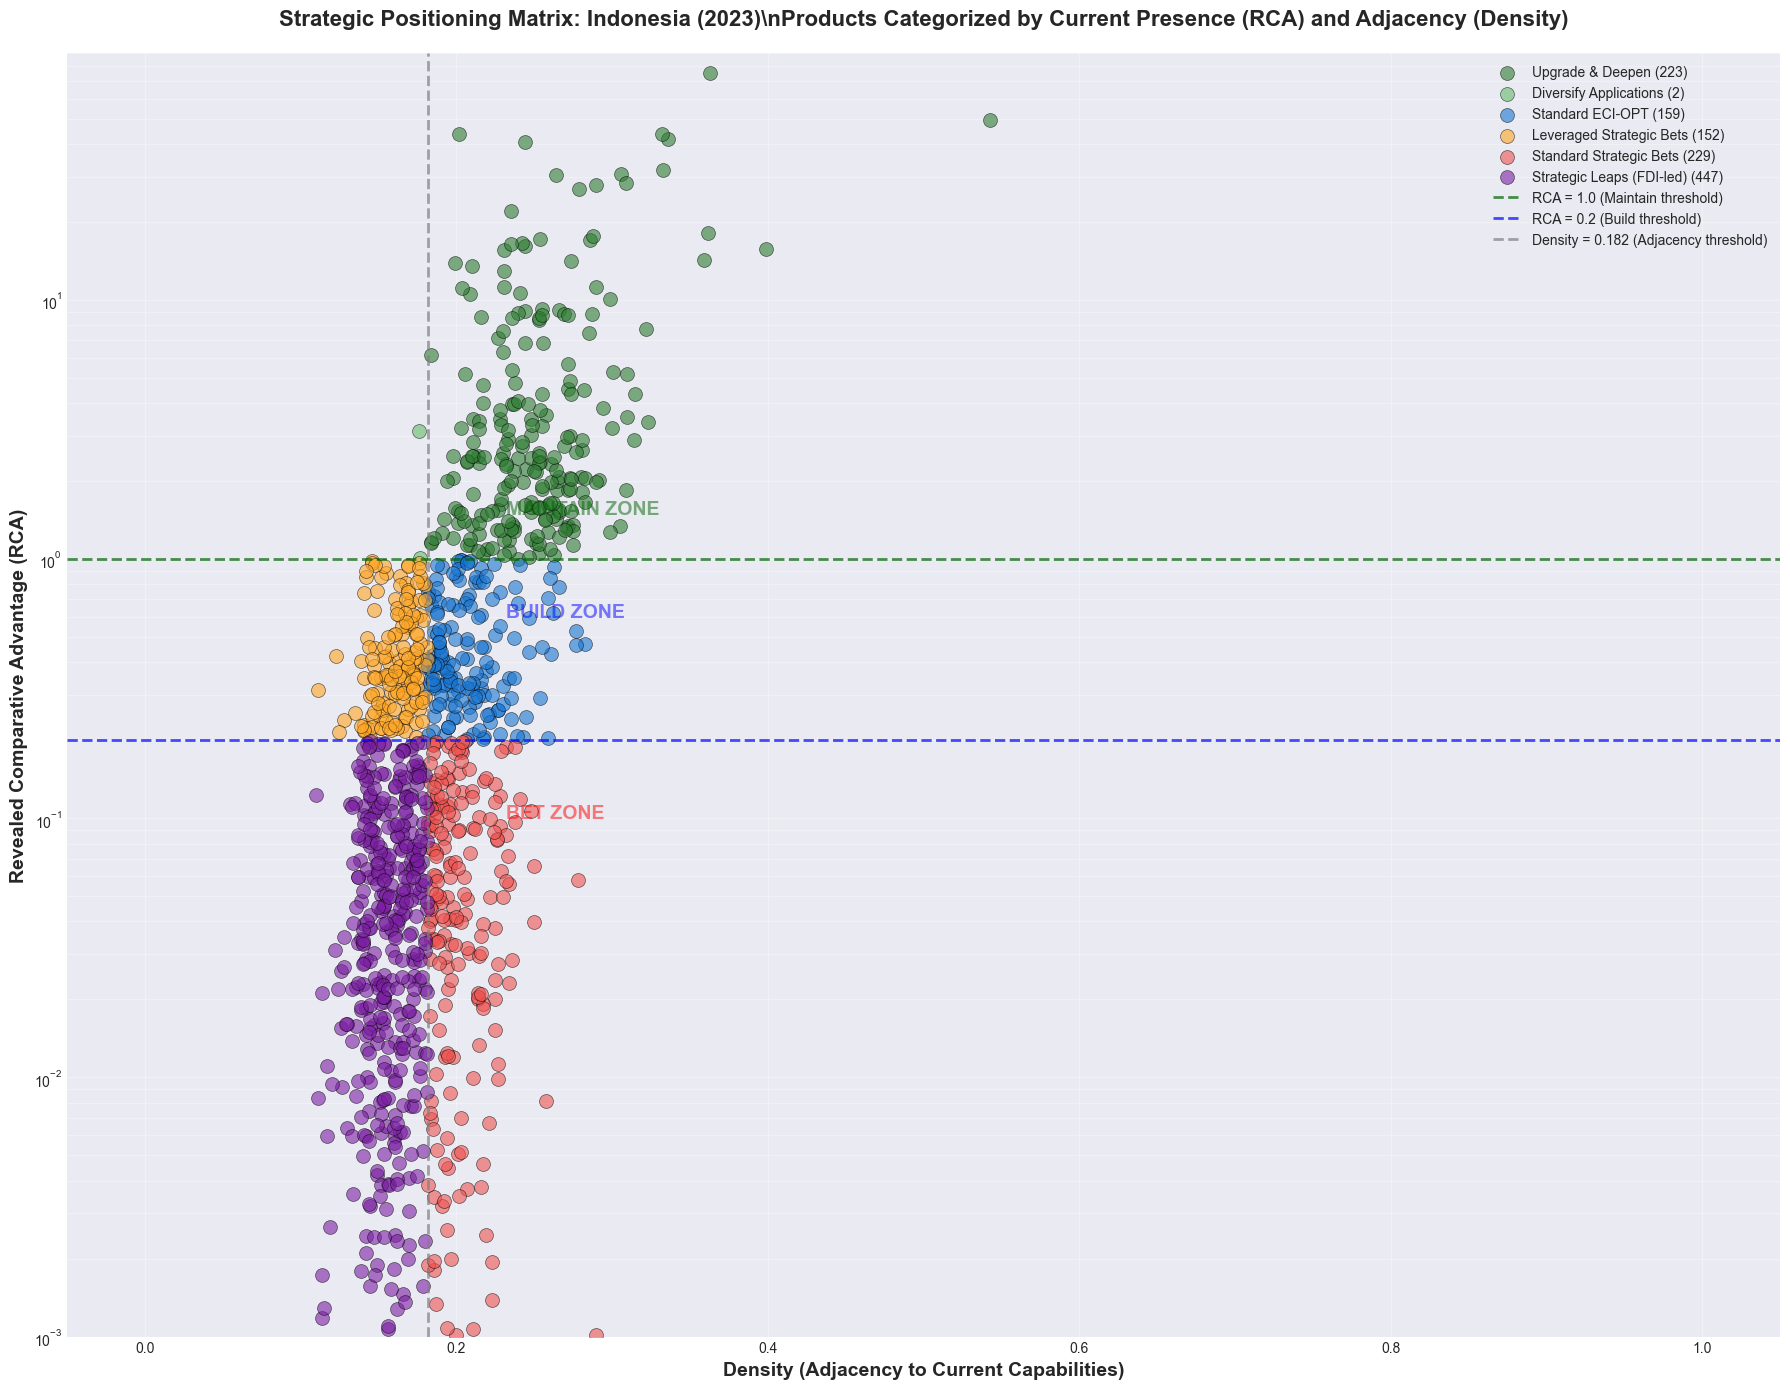

✅ Strategic Positioning Matrix saved: ./output/strategic_bets/strategic_positioning_matrix.png


In [30]:
# Create Strategic Positioning Matrix visualization
fig, ax = plt.subplots(figsize=(18, 14))

# Define zone colors
zone_colors = {
    "Upgrade & Deepen": "#2E7D32",  # Dark green
    "Diversify Applications": "#66BB6A",  # Light green
    "Standard ECI-OPT": "#1976D2",  # Blue
    "Leveraged Strategic Bets": "#FFA726",  # Orange
    "Standard Strategic Bets": "#EF5350",  # Red
    "Strategic Leaps (FDI-led)": "#7B1FA2"  # Purple
}

# Plot all products by zone
for zone, color in zone_colors.items():
    zone_data = df_indonesia[df_indonesia['strategic_zone'] == zone]
    if len(zone_data) > 0:
        ax.scatter(zone_data['density'], zone_data['export_rca'],
                  c=color, s=100, alpha=0.6, label=f'{zone} ({len(zone_data)})',
                  edgecolors='black', linewidths=0.5)

# Add threshold lines
ax.axhline(y=RCA_MAINTAIN, color='darkgreen', linestyle='--', linewidth=2, alpha=0.7, 
          label=f'RCA = {RCA_MAINTAIN} (Maintain threshold)')
ax.axhline(y=RCA_BUILD, color='blue', linestyle='--', linewidth=2, alpha=0.7,
          label=f'RCA = {RCA_BUILD} (Build threshold)')
ax.axvline(x=density_median, color='gray', linestyle='--', linewidth=2, alpha=0.7,
          label=f'Density = {density_median:.3f} (Adjacency threshold)')

# Add zone labels
ax.text(density_median + 0.05, RCA_MAINTAIN + 0.5, "MAINTAIN ZONE", 
       fontsize=14, fontweight='bold', alpha=0.5, color='darkgreen')
ax.text(density_median + 0.05, (RCA_MAINTAIN + RCA_BUILD) / 2, "BUILD ZONE", 
       fontsize=14, fontweight='bold', alpha=0.5, color='blue')
ax.text(density_median + 0.05, RCA_BUILD / 2, "BET ZONE", 
       fontsize=14, fontweight='bold', alpha=0.5, color='red')

# Styling
ax.set_xlabel('Density (Adjacency to Current Capabilities)', fontsize=14, fontweight='bold')
ax.set_ylabel('Revealed Comparative Advantage (RCA)', fontsize=14, fontweight='bold')
ax.set_title(f'Strategic Positioning Matrix: Indonesia ({ANALYSIS_YEAR})\\n' +
            'Products Categorized by Current Presence (RCA) and Adjacency (Density)',
            fontsize=16, fontweight='bold', pad=20)

# Log scale for RCA to better visualize the distribution
ax.set_yscale('log')
ax.set_ylim(0.001, max(df_indonesia['export_rca'].max() * 1.2, 10))
ax.set_xlim(-0.05, 1.05)

ax.legend(loc='upper right', fontsize=10, framealpha=0.95, ncol=1)
ax.grid(True, alpha=0.3, which='both')

plt.tight_layout()
output_file = os.path.join(OUTPUT_DIR, 'strategic_positioning_matrix.png')
plt.savefig(output_file, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Strategic Positioning Matrix saved: {output_file}")

## 13. Export Strategic Positioning Matrix Results

In [37]:
print("Exporting Strategic Positioning Matrix results...\n")

# 1. Complete product classification
all_products_matrix = df_indonesia[[
    'product_hs92_code', 'product_name_short', 'product_name',
    'export_rca', 'density', 'distance', 'pci', 'cog',
    'export_value', 'import_value', 'strategic_zone'
]].copy()
all_products_matrix = all_products_matrix.sort_values(['strategic_zone', 'export_rca'], ascending=[True, False])

output_file = os.path.join(OUTPUT_DIR, 'strategic_positioning_matrix_all_products.csv')
all_products_matrix.to_csv(output_file, index=False)
print(f"✓ {output_file}")

# 2. Export each zone separately
zone_files = {}
for zone in zone_order:
    zone_data = df_indonesia[df_indonesia['strategic_zone'] == zone][[
        'product_hs92_code', 'product_name_short', 'product_name',
        'export_rca', 'density', 'pci', 'cog', 'export_value'
    ]].copy()
    
    # Sort by appropriate metric for each zone
    if 'Maintain' in zone or 'Diversify' in zone:
        zone_data = zone_data.sort_values('export_value', ascending=False)
    else:
        zone_data['efficiency'] = zone_data['pci'] / ((1 - zone_data['density']) + 0.001)
        zone_data = zone_data.sort_values('efficiency', ascending=False)
    
    zone_filename = zone.lower().replace(' ', '_').replace('(', '').replace(')', '').replace('-', '_')
    output_file = os.path.join(OUTPUT_DIR, f'zone_{zone_filename}.csv')
    zone_data.to_csv(output_file, index=False)
    zone_files[zone] = output_file
    print(f"✓ {output_file}")

# 3. Summary statistics by zone
zone_summary = []
for zone in zone_order:
    zone_data = df_indonesia[df_indonesia['strategic_zone'] == zone]
    if len(zone_data) > 0:
        zone_summary.append({
            'Zone': zone,
            'Product_Count': len(zone_data),
            'Pct_of_Total': f"{(len(zone_data) / len(df_indonesia)) * 100:.1f}%",
            'Avg_RCA': zone_data['export_rca'].mean(),
            'Avg_PCI': zone_data['pci'].mean(),
            'Avg_Density': zone_data['density'].mean(),
            'Avg_COG': zone_data['cog'].mean(),
            'Total_Export_Value': zone_data['export_value'].sum(),
            'Pct_Export_Value': f"{(zone_data['export_value'].sum() / df_indonesia['export_value'].sum()) * 100:.1f}%"
        })

zone_summary_df = pd.DataFrame(zone_summary)
output_file = os.path.join(OUTPUT_DIR, 'zone_summary_statistics.csv')
zone_summary_df.to_csv(output_file, index=False)
print(f"✓ {output_file}")

# 4. Priority recommendations by zone
priorities = {
    'Upgrade_Deepen_Priorities': upgrade_deepen.nlargest(10, 'export_value')[[
        'product_hs92_code', 'product_name_short', 'export_value', 'pci', 'export_rca'
    ]] if len(upgrade_deepen) > 0 else pd.DataFrame(),
    
    'Diversify_Applications_Priorities': diversify_apps.nlargest(10, 'export_value')[[
    'product_hs92_code', 'product_name_short', 'export_value', 'export_rca', 'pci', 'density'
    ]] if len(diversify_apps) > 0 else pd.DataFrame(),

    'Standard_ECI_OPT_Top_Opportunities': standard_eciopt.nlargest(10, 'efficiency')[[
        'product_hs92_code', 'product_name_short', 'export_rca', 'pci', 'density', 'efficiency'
    ]] if len(standard_eciopt) > 0 else pd.DataFrame(),
    
    'Leveraged_Bets_Opportunities': leveraged_bets.nlargest(10, 'pci')[[
    'product_hs92_code', 'product_name_short', 'export_rca', 'pci', 'density', 'cog'
    ]] if len(leveraged_bets) > 0 else pd.DataFrame(),
    
    'Standard_Bets_Top_Opportunities': standard_bets[standard_bets['pci'] > 0].nlargest(10, 'efficiency')[[
        'product_hs92_code', 'product_name_short', 'pci', 'density', 'efficiency', 'cog'
    ]] if len(standard_bets) > 0 else pd.DataFrame(),
    
    'Strategic_Leaps_FDI_Targets': strategic_leaps[(strategic_leaps['pci'] > 1.5) & 
                                                   (strategic_leaps['export_rca'] < 0.1)].nlargest(10, 'pci')[[
        'product_hs92_code', 'product_name_short', 'pci', 'cog', 'export_rca'
    ]] if len(strategic_leaps) > 0 else pd.DataFrame()
}

# Export priority lists
with pd.ExcelWriter(os.path.join(OUTPUT_DIR, 'strategic_priorities_by_zone.xlsx'), engine='openpyxl') as writer:
    for sheet_name, df in priorities.items():
        if not df.empty:
            df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✓ {os.path.join(OUTPUT_DIR, 'strategic_priorities_by_zone.xlsx')}")

print(f"\n{'='*100}")
print(f"✅ STRATEGIC POSITIONING MATRIX ANALYSIS COMPLETE!")
print(f"{'='*100}")
print(f"\n📊 Zone Summary:")
display(zone_summary_df)

print(f"\n💡 Key Insights:")
print(f"   • Maintain Zone (RCA ≥ 1.0): {len(upgrade_deepen) + len(diversify_apps)} products")
print(f"   • Build Zone (0.2 ≤ RCA < 1.0): {len(standard_eciopt) + len(leveraged_bets)} products")
print(f"   • Bet Zone (RCA < 0.2): {len(standard_bets) + len(strategic_leaps)} products")
print(f"   • Adjacent Opportunities (High Density): {len(upgrade_deepen) + len(standard_eciopt) + len(standard_bets)} products")
print(f"   • Non-Adjacent (Low Density): {len(diversify_apps) + len(leveraged_bets) + len(strategic_leaps)} products")

Exporting Strategic Positioning Matrix results...

✓ ./output/strategic_bets/strategic_positioning_matrix_all_products.csv
✓ ./output/strategic_bets/zone_upgrade_&_deepen.csv
✓ ./output/strategic_bets/zone_diversify_applications.csv
✓ ./output/strategic_bets/zone_standard_eci_opt.csv
✓ ./output/strategic_bets/zone_leveraged_strategic_bets.csv
✓ ./output/strategic_bets/zone_standard_strategic_bets.csv
✓ ./output/strategic_bets/zone_strategic_leaps_fdi_led.csv
✓ ./output/strategic_bets/zone_summary_statistics.csv
✓ ./output/strategic_bets/strategic_priorities_by_zone.xlsx

✅ STRATEGIC POSITIONING MATRIX ANALYSIS COMPLETE!

📊 Zone Summary:


,Zone,Product_Count,Pct_of_Total,Avg_RCA,Avg_PCI,Avg_Density,Avg_COG,Total_Export_Value,Pct_Export_Value
0,Upgrade & Deepen,223,18.4%,5.927,-0.554,0.251,0.000,196552469667,77.6%
1,Diversify Applications,2,0.2%,2.077,1.064,0.177,0.000,140633034,0.1%
2,Standard ECI-OPT,159,13.1%,0.482,-0.641,0.209,0.237,25382569314,10.0%
3,Leveraged Strategic Bets,152,12.5%,0.452,0.681,0.161,0.883,21009064378,8.3%
4,Standard Strategic Bets,229,18.9%,0.058,-0.723,0.203,0.212,5648641916,2.2%
5,Strategic Leaps (FDI-led),447,36.9%,0.048,0.637,0.156,0.786,4615930175,1.8%



💡 Key Insights:
   • Maintain Zone (RCA ≥ 1.0): 225 products
   • Build Zone (0.2 ≤ RCA < 1.0): 311 products
   • Bet Zone (RCA < 0.2): 676 products
   • Adjacent Opportunities (High Density): 611 products
   • Non-Adjacent (Low Density): 601 products


## 14. Integrated Policy Recommendations: Timeframe × Strategic Zones

In [32]:
print("="*100)
print("INTEGRATED POLICY RECOMMENDATIONS")
print(f"Combining Timeframe Strategy with Strategic Positioning Matrix")
print(f"Indonesia ({ANALYSIS_YEAR})")
print("="*100)

# Create integrated recommendations matrix
recommendations = {
    'short_term': [],
    'medium_term': [],
    'long_term': []
}

print("\n" + "="*100)
print("SHORT-TERM PRIORITIES (1-3 Years): Quick Wins & Capability Building")
print("="*100)

print("\n📈 MAINTAIN ZONE - Upgrade & Deepen:")
print("   Strategy: Enhance quality, increase complexity of existing competitive products")
if len(upgrade_deepen) > 0:
    # Focus on high-value products with upgrade potential
    short_term_maintain = upgrade_deepen[
        (upgrade_deepen['pci'] < upgrade_deepen['pci'].median()) &
        (upgrade_deepen['export_value'] > upgrade_deepen['export_value'].quantile(0.75))
    ].nlargest(5, 'export_value')
    
    if len(short_term_maintain) > 0:
        print("\n   🎯 Priority Upgrades (High value, room for complexity increase):")
        for idx, row in short_term_maintain.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        Export: ${row['export_value']:,.0f}, PCI: {row['pci']:.3f} → Target: {row['pci'] + 0.5:.3f}")
            recommendations['short_term'].append({
                'zone': 'Upgrade & Deepen',
                'hs_code': row['product_hs92_code'],
                'product': row['product_name_short'],
                'action': 'Quality upgrade & value chain enhancement',
                'current_export': row['export_value'],
                'current_pci': row['pci']
            })
    
    print("\n   💡 Policy Instruments:")
    print("      • Quality certification programs (ISO, sustainability standards)")
    print("      • R&D tax incentives for product innovation")
    print("      • Export promotion to premium markets")
    print("      • Technology adoption subsidies")

print("\n🚀 BUILD ZONE - Standard ECI-OPT (Near Breakthrough):")
print("   Strategy: Push emerging products past RCA = 1.0 threshold")
if len(standard_eciopt) > 0:
    # Near-threshold products (0.8 ≤ RCA < 1.0)
    near_breakthrough = standard_eciopt[
        (standard_eciopt['export_rca'] >= 0.7)
    ].nlargest(5, 'export_rca')
    
    if len(near_breakthrough) > 0:
        print("\n   🎯 Near Breakthrough Products (RCA ≥ 0.7):")
        for idx, row in near_breakthrough.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        RCA: {row['export_rca']:.3f} → Target: ≥1.0, PCI: {row['pci']:.3f}, Density: {row['density']:.3f}")
            recommendations['short_term'].append({
                'zone': 'Standard ECI-OPT',
                'hs_code': row['product_hs92_code'],
                'product': row['product_name_short'],
                'action': 'Scale up production & market penetration',
                'current_rca': row['export_rca'],
                'target_rca': 1.0
            })
    
    print("\n   💡 Policy Instruments:")
    print("      • Export financing & credit guarantees")
    print("      • Market access support (trade missions, exhibitions)")
    print("      • Capacity expansion grants")
    print("      • Cluster development programs")

print("\n🎯 BET ZONE - Standard Strategic Bets (High Feasibility):")
print("   Strategy: Leverage current capabilities for quick entry")
if len(standard_bets) > 0:
    # High density, positive complexity opportunities
    quick_wins = standard_bets[
        (standard_bets['pci'] > 0) &
        (standard_bets['density'] > standard_bets['density'].quantile(0.75))
    ].nlargest(5, 'density')
    
    if len(quick_wins) > 0:
        print("\n   🎯 Quick Win Opportunities (Very High Density):")
        for idx, row in quick_wins.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        Density: {row['density']:.3f}, PCI: {row['pci']:.3f}, COG: {row['cog']:.3f}")
            recommendations['short_term'].append({
                'zone': 'Standard Strategic Bets',
                'hs_code': row['product_hs92_code'],
                'product': row['product_name_short'],
                'action': 'Pilot projects leveraging existing capabilities',
                'density': row['density'],
                'pci': row['pci']
            })
    
    print("\n   💡 Policy Instruments:")
    print("      • Demonstration projects & pilot schemes")
    print("      • Technical training for existing workforce")
    print("      • Match-making with existing supply chains")
    print("      • Risk-sharing mechanisms")

print("\n" + "="*100)

INTEGRATED POLICY RECOMMENDATIONS
Combining Timeframe Strategy with Strategic Positioning Matrix
Indonesia (2023)

SHORT-TERM PRIORITIES (1-3 Years): Quick Wins & Capability Building

📈 MAINTAIN ZONE - Upgrade & Deepen:
   Strategy: Enhance quality, increase complexity of existing competitive products

   🎯 Priority Upgrades (High value, room for complexity increase):
      • 2701: Coal
        Export: $32,822,622,303, PCI: -1.816 → Target: -1.316
      • 1511: Palm oil
        Export: $21,740,433,933, PCI: -1.893 → Target: -1.393
      • 7202: Ferroalloys
        Export: $14,346,149,272, PCI: -1.099 → Target: -0.599
      • 2711: Petroleum gases
        Export: $8,442,707,061, PCI: -1.702 → Target: -1.202
      • 2603: Copper ore
        Export: $8,012,782,146, PCI: -2.000 → Target: -1.500

   💡 Policy Instruments:
      • Quality certification programs (ISO, sustainability standards)
      • R&D tax incentives for product innovation
      • Export promotion to premium markets
      •

In [33]:
print("MEDIUM-TERM PRIORITIES (3-5 Years): Strategic Diversification & Capability Building")
print("="*100)

print("\n🎯 BUILD ZONE - Standard ECI-OPT (Balanced Opportunities):")
print("   Strategy: Systematic diversification along adjacent paths")
if len(standard_eciopt) > 0:
    # Calculate efficiency for standard ECI-OPT
    standard_eciopt_med = standard_eciopt.copy()
    standard_eciopt_med['efficiency'] = standard_eciopt_med['pci'] / (standard_eciopt_med['distance'] + 0.001)
    
    # Balance of complexity and feasibility
    balanced_eciopt = standard_eciopt_med[
        (standard_eciopt_med['pci'] > standard_eciopt_med['pci'].median()) &
        (standard_eciopt_med['density'] >= standard_eciopt_med['density'].quantile(0.33))
    ].nlargest(8, 'efficiency')
    
    if len(balanced_eciopt) > 0:
        print("\n   🎯 Balanced Diversification Targets:")
        for idx, row in balanced_eciopt.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        RCA: {row['export_rca']:.3f}, PCI: {row['pci']:.3f}, Density: {row['density']:.3f}, Eff: {row['efficiency']:.3f}")
            recommendations['medium_term'].append({
                'zone': 'Standard ECI-OPT',
                'hs_code': row['product_hs92_code'],
                'product': row['product_name_short'],
                'action': 'Systematic capability development',
                'pci': row['pci'],
                'density': row['density']
            })
    
    print("\n   💡 Policy Instruments:")
    print("      • Industry-specific capability building programs")
    print("      • Technology acquisition support")
    print("      • Supply chain development initiatives")
    print("      • Skills development aligned with target products")

print("\n🎯 BUILD ZONE - Leveraged Strategic Bets:")
print("   Strategy: Build on emerging presence despite low adjacency")
if len(leveraged_bets) > 0:
    # Products with decent RCA but low density - calculated risks
    leveraged_med = leveraged_bets[
        (leveraged_bets['export_rca'] >= 0.4) &
        (leveraged_bets['pci'] > 0)
    ].nlargest(5, 'pci')
    
    if len(leveraged_med) > 0:
        print("\n   🎯 Calculated Risk Opportunities (Some foundation, higher complexity):")
        for idx, row in leveraged_med.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        RCA: {row['export_rca']:.3f}, PCI: {row['pci']:.3f}, Density: {row['density']:.3f}")
            recommendations['medium_term'].append({
                'zone': 'Leveraged Strategic Bets',
                'hs_code': row['product_hs92_code'],
                'product': row['product_name_short'],
                'action': 'Targeted capability acquisition',
                'current_rca': row['export_rca'],
                'pci': row['pci']
            })
    
    print("\n   💡 Policy Instruments:")
    print("      • Joint ventures with technology leaders")
    print("      • Specialized technical education programs")
    print("      • Targeted infrastructure development")
    print("      • Innovation ecosystems for specific sectors")

print("\n🎯 BET ZONE - Standard Strategic Bets (High Efficiency):")
print("   Strategy: Enter new products with strong efficiency ratios")
if len(standard_bets) > 0:
    # High efficiency bets with positive complexity
    standard_bets_med = standard_bets.copy()
    standard_bets_med['efficiency'] = standard_bets_med['pci'] / (standard_bets_med['distance'] + 0.001)
    
    high_efficiency_bets = standard_bets_med[
        (standard_bets_med['pci'] > 0.5) &
        (standard_bets_med['efficiency'] > standard_bets_med['efficiency'].quantile(0.75))
    ].nlargest(8, 'efficiency')
    
    if len(high_efficiency_bets) > 0:
        print("\n   🎯 High-Efficiency New Products:")
        for idx, row in high_efficiency_bets.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        PCI: {row['pci']:.3f}, Density: {row['density']:.3f}, Eff: {row['efficiency']:.3f}, COG: {row['cog']:.3f}")
            recommendations['medium_term'].append({
                'zone': 'Standard Strategic Bets',
                'hs_code': row['product_hs92_code'],
                'product': row['product_name_short'],
                'action': 'New product development with capability leverage',
                'efficiency': row['efficiency'],
                'cog': row['cog']
            })
    
    print("\n   💡 Policy Instruments:")
    print("      • Industry incubation programs")
    print("      • Public-private R&D partnerships")
    print("      • First-mover advantage support")
    print("      • Market development assistance")

print("\n" + "="*100)

MEDIUM-TERM PRIORITIES (3-5 Years): Strategic Diversification & Capability Building

🎯 BUILD ZONE - Standard ECI-OPT (Balanced Opportunities):
   Strategy: Systematic diversification along adjacent paths

   🎯 Balanced Diversification Targets:
      • 8527: Reception apparatus for radio broadcasting
        RCA: 0.670, PCI: 0.952, Density: 0.195, Eff: 1.181
      • 4007: Vulcanized rubber thread and cord
        RCA: 0.509, PCI: 0.839, Density: 0.225, Eff: 1.081
      • 8529: Parts of radios, telephones, and T.V.s
        RCA: 0.332, PCI: 0.824, Density: 0.208, Eff: 1.039
      • 8541: Semiconductor devices
        RCA: 0.219, PCI: 0.560, Density: 0.215, Eff: 0.712
      • 9403: Other furniture and parts
        RCA: 0.886, PCI: 0.240, Density: 0.198, Eff: 0.299
      • 7604: Aluminum bars
        RCA: 0.638, PCI: 0.139, Density: 0.202, Eff: 0.174
      • 4017: Hard rubber
        RCA: 0.226, PCI: 0.108, Density: 0.195, Eff: 0.134
      • 4411: Fiberboard of wood
        RCA: 0.920, PC

In [34]:
print("LONG-TERM PRIORITIES (5-10 Years): Transformational Leaps & Complexity Frontiers")
print("="*100)

print("\n📈 MAINTAIN ZONE - Upgrade to Highest Complexity:")
print("   Strategy: Transform current exports into most complex variants")
if len(upgrade_deepen) > 0:
    # High value products that could reach high complexity
    transformation_targets = upgrade_deepen.nlargest(5, 'export_value')
    
    if len(transformation_targets) > 0:
        print("\n   🎯 Long-term Transformation Targets (Move to frontier):")
        for idx, row in transformation_targets.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        Current: ${row['export_value']:,.0f}, PCI: {row['pci']:.3f}")
            print(f"        Target: High-tech variants, PCI > 1.5, premium markets")
            recommendations['long_term'].append({
                'zone': 'Upgrade & Deepen',
                'hs_code': row['product_hs92_code'],
                'product': row['product_name_short'],
                'action': 'Frontier transformation - highest complexity variants',
                'current_export': row['export_value']
            })
    
    print("\n   💡 Policy Instruments:")
    print("      • National innovation missions for key sectors")
    print("      • Advanced R&D centers & technology parks")
    print("      • Global talent attraction programs")
    print("      • IP development & commercialization support")

print("\n🚀 BET ZONE - Strategic Leaps (FDI-led):")
print("   Strategy: Major capability jumps into high-complexity products")
if len(strategic_leaps) > 0:
    # High complexity leaps with strong future value
    strategic_leaps_long = strategic_leaps.copy()
    strategic_leaps_long['efficiency'] = strategic_leaps_long['pci'] / (strategic_leaps_long['distance'] + 0.001)
    
    transformational_leaps = strategic_leaps_long[
        (strategic_leaps_long['pci'] > 1.5) &
        (strategic_leaps_long['cog'] > strategic_leaps_long['cog'].median())
    ].nlargest(10, 'pci')
    
    if len(transformational_leaps) > 0:
        print("\n   🎯 Transformational Leap Targets (PCI > 1.5, High COG):")
        for idx, row in transformational_leaps.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        PCI: {row['pci']:.3f}, COG: {row['cog']:.3f}, Density: {row['density']:.3f}")
            recommendations['long_term'].append({
                'zone': 'Strategic Leaps (FDI-led)',
                'hs_code': row['product_hs92_code'],
                'product': row['product_name_short'],
                'action': 'FDI-led capability jump',
                'pci': row['pci'],
                'cog': row['cog']
            })
    
    print("\n   💡 Policy Instruments:")
    print("      • Strategic FDI attraction in high-tech sectors")
    print("      • Technology transfer agreements")
    print("      • Special economic zones for advanced manufacturing")
    print("      • Long-term university-industry partnerships")
    print("      • Sovereign wealth fund investments in strategic sectors")

print("\n🔮 BET ZONE - Gateway Products (Highest COG):")
print("   Strategy: Products that open pathways to many complex products")
if len(strategic_leaps) > 0:
    # Products with highest future value regardless of current complexity
    gateway_products = strategic_leaps[
        (strategic_leaps['cog'] > strategic_leaps['cog'].quantile(0.9)) &
        (strategic_leaps['pci'] > 0)
    ].nlargest(5, 'cog')
    
    if len(gateway_products) > 0:
        print("\n   🎯 Gateway Products (Top 10% COG - Future Diversification Potential):")
        for idx, row in gateway_products.iterrows():
            print(f"      • {row['product_hs92_code']}: {row['product_name_short'][:50]}")
            print(f"        COG: {row['cog']:.3f}, PCI: {row['pci']:.3f}")
            print(f"        Rationale: Gateway to many adjacent complex products")
            recommendations['long_term'].append({
                'zone': 'Strategic Leaps (Gateway)',
                'hs_code': row['product_hs92_code'],
                'product': row['product_name_short'],
                'action': 'Gateway product - foundation for future diversification',
                'cog': row['cog']
            })
    
    print("\n   💡 Policy Instruments:")
    print("      • National strategic initiatives")
    print("      • Multi-year research programs")
    print("      • Regional innovation hubs")
    print("      • International collaboration frameworks")

print("\n🎯 Cross-Cutting Long-term Initiatives:")
print("   • National Economic Complexity Strategy (10-year roadmap)")
print("   • Industrial Policy aligned with complexity pathways")
print("   • Education system transformation (STEM, vocational)")
print("   • National innovation ecosystem development")
print("   • Global value chain integration strategy")

print("\n" + "="*100)

LONG-TERM PRIORITIES (5-10 Years): Transformational Leaps & Complexity Frontiers

📈 MAINTAIN ZONE - Upgrade to Highest Complexity:
   Strategy: Transform current exports into most complex variants

   🎯 Long-term Transformation Targets (Move to frontier):
      • 2701: Coal
        Current: $32,822,622,303, PCI: -1.816
        Target: High-tech variants, PCI > 1.5, premium markets
      • 1511: Palm oil
        Current: $21,740,433,933, PCI: -1.893
        Target: High-tech variants, PCI > 1.5, premium markets
      • 7202: Ferroalloys
        Current: $14,346,149,272, PCI: -1.099
        Target: High-tech variants, PCI > 1.5, premium markets
      • 2711: Petroleum gases
        Current: $8,442,707,061, PCI: -1.702
        Target: High-tech variants, PCI > 1.5, premium markets
      • 2603: Copper ore
        Current: $8,012,782,146, PCI: -2.000
        Target: High-tech variants, PCI > 1.5, premium markets

   💡 Policy Instruments:
      • National innovation missions for key sectors

In [35]:
# Export integrated policy recommendations
print("\n📁 Exporting Integrated Policy Recommendations...\n")

# Create comprehensive policy recommendation dataframes
short_term_df = pd.DataFrame(recommendations['short_term'])
medium_term_df = pd.DataFrame(recommendations['medium_term'])
long_term_df = pd.DataFrame(recommendations['long_term'])

# Export to Excel with multiple sheets
excel_path = os.path.join(OUTPUT_DIR, 'integrated_policy_recommendations.xlsx')
with pd.ExcelWriter(excel_path, engine='openpyxl') as writer:
    if not short_term_df.empty:
        short_term_df.to_excel(writer, sheet_name='Short_Term_1-3yr', index=False)
    if not medium_term_df.empty:
        medium_term_df.to_excel(writer, sheet_name='Medium_Term_3-5yr', index=False)
    if not long_term_df.empty:
        long_term_df.to_excel(writer, sheet_name='Long_Term_5-10yr', index=False)
    
    # Summary sheet
    summary_data = {
        'Timeframe': ['Short-term (1-3yr)', 'Medium-term (3-5yr)', 'Long-term (5-10yr)'],
        'Priority_Count': [len(short_term_df), len(medium_term_df), len(long_term_df)],
        'Primary_Focus': [
            'Quick wins, near-breakthrough products, capability leverage',
            'Strategic diversification, balanced complexity gains',
            'Transformational leaps, frontier products, FDI-led'
        ],
        'Key_Zones': [
            'Upgrade & Deepen, Standard ECI-OPT, Standard Strategic Bets',
            'Standard ECI-OPT, Leveraged Bets, Standard Strategic Bets',
            'Strategic Leaps, Gateway Products, Frontier Transformation'
        ]
    }
    summary_df = pd.DataFrame(summary_data)
    summary_df.to_excel(writer, sheet_name='Summary', index=False)

print(f"✓ {excel_path}")

# Also create a master policy roadmap CSV
all_recommendations = []
for timeframe, recs in recommendations.items():
    for rec in recs:
        rec_copy = rec.copy()
        rec_copy['timeframe'] = timeframe
        all_recommendations.append(rec_copy)

if all_recommendations:
    master_roadmap = pd.DataFrame(all_recommendations)
    master_roadmap = master_roadmap[['timeframe', 'zone', 'hs_code', 'product', 'action'] + 
                                    [col for col in master_roadmap.columns if col not in 
                                     ['timeframe', 'zone', 'hs_code', 'product', 'action']]]
    
    csv_path = os.path.join(OUTPUT_DIR, 'master_policy_roadmap.csv')
    master_roadmap.to_csv(csv_path, index=False)
    print(f"✓ {csv_path}")

print(f"\n{'='*100}")
print(f"✅ INTEGRATED POLICY RECOMMENDATIONS COMPLETE!")
print(f"{'='*100}")

print(f"\n📊 Summary Statistics:")
print(f"   • Short-term priorities: {len(short_term_df)} products")
print(f"   • Medium-term priorities: {len(medium_term_df)} products")
print(f"   • Long-term priorities: {len(long_term_df)} products")
print(f"   • Total strategic roadmap: {len(all_recommendations)} recommendations")

print(f"\n🎯 Strategic Portfolio Balance:")
maintain_count = sum(1 for r in all_recommendations if 'Upgrade' in r.get('zone', '') or 'Diversify' in r.get('zone', ''))
build_count = sum(1 for r in all_recommendations if 'ECI-OPT' in r.get('zone', '') or 'Leveraged' in r.get('zone', ''))
bet_count = sum(1 for r in all_recommendations if 'Strategic Bets' in r.get('zone', '') or 'Strategic Leaps' in r.get('zone', ''))

print(f"   • Maintain Zone (enhance existing): {maintain_count} ({maintain_count/len(all_recommendations)*100:.0f}%)")
print(f"   • Build Zone (emerging products): {build_count} ({build_count/len(all_recommendations)*100:.0f}%)")
print(f"   • Bet Zone (new products): {bet_count} ({bet_count/len(all_recommendations)*100:.0f}%)")

print(f"\n💡 Next Steps for Implementation:")
print(f"   1. Establish inter-ministerial coordination committee")
print(f"   2. Assign lead agencies for each strategic zone")
print(f"   3. Allocate budget across timeframes (weighted toward short-term)")
print(f"   4. Set up monitoring & evaluation framework")
print(f"   5. Launch pilot projects for high-priority products")
print(f"   6. Engage private sector through PPPs")
print(f"   7. Review and update recommendations annually")


📁 Exporting Integrated Policy Recommendations...

✓ ./output/strategic_bets/integrated_policy_recommendations.xlsx
✓ ./output/strategic_bets/master_policy_roadmap.csv

✅ INTEGRATED POLICY RECOMMENDATIONS COMPLETE!

📊 Summary Statistics:
   • Short-term priorities: 10 products
   • Medium-term priorities: 21 products
   • Long-term priorities: 20 products
   • Total strategic roadmap: 51 recommendations

🎯 Strategic Portfolio Balance:
   • Maintain Zone (enhance existing): 10 (20%)
   • Build Zone (emerging products): 18 (35%)
   • Bet Zone (new products): 28 (55%)

💡 Next Steps for Implementation:
   1. Establish inter-ministerial coordination committee
   2. Assign lead agencies for each strategic zone
   3. Allocate budget across timeframes (weighted toward short-term)
   4. Set up monitoring & evaluation framework
   5. Launch pilot projects for high-priority products
   6. Engage private sector through PPPs
   7. Review and update recommendations annually
